<a id='introduction'></a>
# 1. Introduction: Why Graphs for Molecules?

**⏱️ Expected time:** 10 minutes

## The Challenge of Molecular Representation

Molecules are complex 3D structures with atoms connected by chemical bonds. How should we represent them for machine learning?

### Traditional Approaches

1. **SMILES Strings** → Treat as text sequences
2. **Molecular Descriptors** → Hand-crafted features (MW, logP, TPSA, etc.)
3. **Fingerprints** → Binary vectors (Morgan, MACCS, etc.)

### The Graph Representation Advantage

A **graph** is a natural way to represent molecules:
- **Nodes (Vertices)** = Atoms
- **Edges (Links)** = Chemical bonds
- **Node features** = Atom properties (element, charge, hybridization)
- **Edge features** = Bond properties (type, stereochemistry)

<div align="center">
<img src="https://github.com/beangoben/chemistry_ml_colab/blob/master/images/Chloroquine-2D-molecular-graph.png?raw=1" width="500"/>
</div>

### Why This Matters

> **Inductive Bias**: Graphs encode the assumption that molecular properties are determined by:
> 1. The types of atoms present
> 2. How atoms are connected
> 3. Local chemical environments (neighborhoods)

This is exactly how chemists think about molecules!

# Graph Neural Networks for Molecular Property Prediction

**Molecular Machine Learning Course - GNN Studio**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_REPO/GNN_Molecular_Property_Prediction.ipynb)

---

## Learning Objectives

By the end of this tutorial, you will be able to:

1. **Understand** why graph representations are natural for molecular data
2. **Construct** molecular graphs from SMILES strings with atom and bond features
3. **Implement** message-passing neural networks (MPNNs) using PyTorch Geometric
4. **Train** and evaluate GNN models for molecular property prediction
5. **Use** production-ready tools like Chemprop for real-world applications
6. **Debug** common issues in GNN training pipelines

---

## Table of Contents

0. [Setup & Environment](#setup)
1. [Introduction: Why Graphs for Molecules?](#introduction)
2. [Molecular Graph Construction](#graph-construction)
3. [The ESOL Solubility Dataset](#dataset)
4. [Message-Passing Neural Networks - Theory](#mpnn-theory)
5. [Implementing MPNN with PyTorch Geometric](#mpnn-implementation)
6. [Training and Evaluation](#training)
7. [Understanding Learned Representations](#representations)
8. [Chemprop - Production-Ready GNNs](#chemprop)
9. [Common Pitfalls and Debugging](#debugging)
10. [Extensions and Next Steps](#extensions)

---

## Authors and Acknowledgments

**Developed by:** Gomes Research Group, CMU  
**Based on:** AI4Chem course materials (Schwallergroup)  
**Last Updated:** December 2024  

---

<a id='setup'></a>
# 0. Setup & Environment

**⏱️ Expected runtime:** 2-3 minutes

This section installs all required packages and sets up the environment for reproducible experiments.

In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✓ Running in local environment")

✓ Running in Google Colab


## 0.1 Package Installation

We'll install the latest stable versions of:
- **PyTorch 2.x** - Deep learning framework
- **PyTorch Geometric 2.6+** - Graph neural network library  
- **PyTorch Lightning 2.x** - High-level training framework
- **RDKit** - Cheminformatics toolkit
- **Chemprop v2.2.1** - Production-ready molecular ML
- **Weights & Biases** - Experiment tracking

In [2]:
%%bash
# Install uv first for faster package management
pip install -q uv

# Install PyTorch with CUDA 11.8 support (for Colab T4 GPUs)
uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric and dependencies
uv pip install torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Install other ML packages
uv pip install pytorch-lightning==2.1.0 wandb rdkit ogb deepchem scikit-learn pandas matplotlib seaborn plotly tqdm

# Install Chemprop v2
uv pip install chemprop==2.2.1

echo "✓ Package installation complete!"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 126.9 MB/s eta 0:00:00
✓ Package installation complete!


Using Python 3.12.12 environment at: /usr
Audited 3 packages in 126ms
Using Python 3.12.12 environment at: /usr
Resolved 23 packages in 226ms
Prepared 1 package in 96ms
Installed 1 package in 12ms
 + torch-geometric==2.7.0
Using Python 3.12.12 environment at: /usr
Resolved 82 packages in 593ms
Prepared 8 packages in 568ms
Installed 8 packages in 23ms
 + deepchem==2.8.0
 + lightning-utilities==0.15.2
 + littleutils==0.2.4
 + ogb==1.3.6
 + outdated==0.2.2
 + pytorch-lightning==2.1.0
 + rdkit==2025.9.2
 + torchmetrics==1.8.2
Using Python 3.12.12 environment at: /usr
Resolved 72 packages in 1.22s
Prepared 10 packages in 184ms
Installed 10 packages in 12ms
 + aimsim-core==2.2.3
 + astartes==1.3.3
 + chemprop==2.2.1
 + configargparse==1.7.1
 + descriptastorus==2.8.0
 + lightning==2.6.0
 + mhfp==1.9.6
 + mordredcommunity==2.0.6
 + padelpy==0.1.16
 + pandas-flavor==0.8.1


## 0.2 Download Data

We'll use the **ESOL (Estimated SOLubility)** dataset, which contains aqueous solubility measurements for 1,128 small organic molecules.

**Reference:** Delaney, J. S. (2004). *ESOL: Estimating Aqueous Solubility Directly from Molecular Structure.* J. Chem. Inf. Comput. Sci., 44(3), 1000-1005.

In [3]:
%%bash
# Create data directory
mkdir -p data

# Download ESOL dataset
wget -q https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv -O data/esol.csv

echo "✓ Data download complete!"
echo "Files in data directory:"
ls -lh data/

✓ Data download complete!
Files in data directory:
total 96K
-rw-r--r-- 1 root root 95K Jul 10  2020 esol.csv


## 0.3 Import Libraries

In [4]:
# Standard library
import os
import random
import warnings
from pathlib import Path
from typing import Optional, Tuple, List

# Scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# PyTorch Geometric
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import NNConv, global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn import MLP, GCNConv, GINConv, GATConv
from torch_geometric.utils import to_networkx

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Cheminformatics
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

# OGB utilities
from ogb.utils import smiles2graph
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

# Experiment tracking
import wandb

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure RDKit visualization
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 300, 300

print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ PyTorch Geometric version: {torch_geometric.__version__}")
print(f"✓ PyTorch Lightning version: {pl.__version__}")
print(f"✓ RDKit version: {rdkit.__version__}")

✓ PyTorch version: 2.9.0+cu126
✓ PyTorch Geometric version: 2.7.0
✓ PyTorch Lightning version: 2.1.0
✓ RDKit version: 2025.09.2


## 0.4 GPU Detection and Setup

In [5]:
# Check GPU availability
print("=" * 60)
print("HARDWARE DETECTION")
print("=" * 60)

if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"  - CUDA Version: {torch.version.cuda}")
    print(f"  - Device Capability: {torch.cuda.get_device_capability(0)}")
    print(f"  - Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    print("⚠️  No GPU detected - using CPU")
    if IN_COLAB:
        print("\n💡 To enable GPU in Colab:")
        print("   Runtime → Change runtime type → Hardware accelerator → GPU")
    device = torch.device('cpu')

print(f"\n✓ Using device: {device}")
print("=" * 60)

HARDWARE DETECTION
✓ GPU Available: NVIDIA L4
  - CUDA Version: 12.6
  - Device Capability: (8, 9)
  - Total Memory: 23.80 GB

✓ Using device: cuda


## 0.5 Reproducibility Setup

Setting random seeds ensures that:
1. Model weights are initialized identically
2. Data shuffling is deterministic
3. Results are reproducible across runs

This is **critical** for debugging and comparing different architectures.

In [6]:
def set_seed(seed: int = 42):
    """
    Set random seeds for reproducibility across all libraries.

    Args:
        seed: Random seed value (default: 42)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Deterministic operations (may reduce performance slightly)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # PyTorch Lightning
    pl.seed_everything(seed, workers=True)

    # Environment variable for deterministic algorithms
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f"✓ Random seed set to {seed} for reproducibility")

# Set seed for this session
RANDOM_SEED = 42
set_seed(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 42


✓ Random seed set to 42 for reproducibility


## 0.6 Visualization Setup (Gomes Group Style)

In [7]:
# Gomes Group color palette
GOMES_COLORS = {
    'teal': '#00D9FF',
    'coral': '#FF6B6B',
    'navy': '#0A1628',
    'light_teal': '#7FEFFF',
    'dark_teal': '#00A8CC',
    'light_coral': '#FF9999',
    'dark_coral': '#CC5555',
    'gray': '#95A5A6',
    'white': '#FFFFFF'
}

# Configure matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Seaborn configuration
sns.set_palette([GOMES_COLORS['teal'], GOMES_COLORS['coral'],
                 GOMES_COLORS['gray'], GOMES_COLORS['navy']])

print("✓ Visualization style configured (Gomes Group aesthetic)")

✓ Visualization style configured (Gomes Group aesthetic)


## 0.7 Utility Functions

In [8]:
def print_section_header(title: str, emoji: str = "📚"):
    """
    Print a formatted section header.
    """
    print("\n" + "=" * 70)
    print(f"{emoji}  {title}")
    print("=" * 70 + "\n")

def print_metrics(metrics: dict, title: str = "Metrics"):
    """
    Pretty print evaluation metrics.
    """
    print(f"\n{title}:")
    print("-" * 40)
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"  {key:.<30} {value:.4f}")
        else:
            print(f"  {key:.<30} {value}")
    print("-" * 40)

def estimate_runtime(gpu: bool = True) -> str:
    """
    Return estimated runtime string based on hardware.
    """
    if gpu:
        return "⏱️ Expected runtime: ~2-3 minutes (GPU)"
    else:
        return "⏱️ Expected runtime: ~8-10 minutes (CPU)"

print("✓ Utility functions loaded")

✓ Utility functions loaded


---

**✅ Setup Complete!**

You're now ready to start learning about Graph Neural Networks for molecular property prediction.

---

<a id='introduction'></a>
# 1. Introduction: Why Graphs for Molecules?

**⏱️ Expected time:** 10 minutes

## The Challenge of Molecular Representation

Molecules are complex 3D structures with atoms connected by chemical bonds. How should we represent them for machine learning?

### Traditional Approaches

1. **SMILES Strings** → Treat as text sequences
2. **Molecular Descriptors** → Hand-crafted features (MW, logP, TPSA, etc.)
3. **Fingerprints** → Binary vectors (Morgan, MACCS, etc.)

### The Graph Representation Advantage

A **graph** is a natural way to represent molecules:
- **Nodes (Vertices)** = Atoms
- **Edges (Links)** = Chemical bonds
- **Node features** = Atom properties (element, charge, hybridization)
- **Edge features** = Bond properties (type, stereochemistry)

<div align="center">
<img src="https://github.com/beangoben/chemistry_ml_colab/blob/master/images/Chloroquine-2D-molecular-graph.png?raw=1" width="500"/>
</div>

### Why This Matters

> **Inductive Bias**: Graphs encode the assumption that molecular properties are determined by:
> 1. The types of atoms present
> 2. How atoms are connected
> 3. Local chemical environments (neighborhoods)

This is exactly how chemists think about molecules!


🔬  Visualizing Molecular Graphs



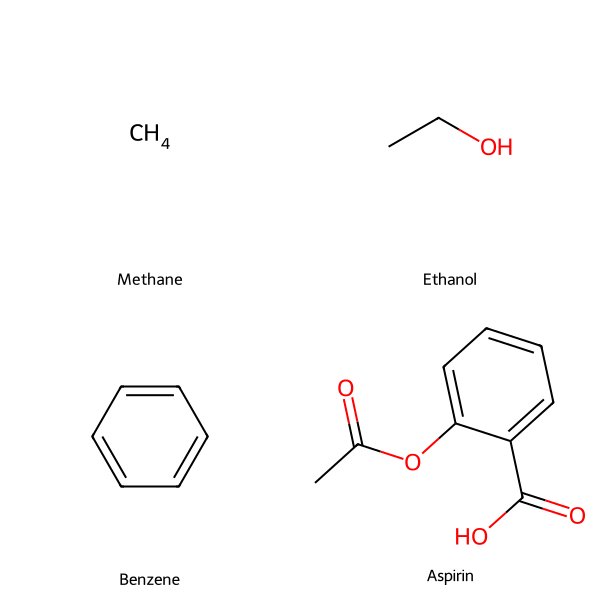


✓ Each molecule is represented as a graph:
  - Nodes: atoms (C, O, H, etc.)
  - Edges: bonds (single, double, aromatic)


In [9]:
print_section_header("Visualizing Molecular Graphs", "🔬")

# Example molecules of increasing complexity
molecules = {
    'Methane': 'C',
    'Ethanol': 'CCO',
    'Benzene': 'c1ccccc1',
    'Aspirin': 'CC(=O)Oc1ccccc1C(=O)O'
}

# Visualize molecules
mols = [Chem.MolFromSmiles(smi) for smi in molecules.values()]
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=2,
    subImgSize=(300, 300),
    legends=list(molecules.keys())
)
display(img)

print("\n✓ Each molecule is represented as a graph:")
print("  - Nodes: atoms (C, O, H, etc.)")
print("  - Edges: bonds (single, double, aromatic)")

## Graph Theory Basics

A graph $G = (V, E)$ consists of:

- **Vertices (Nodes)**: $V = \{v_1, v_2, ..., v_n\}$
- **Edges**: $E \subseteq \{(i,j) | i,j \in V, i \neq j\}$

For molecules, we typically use **undirected graphs** (bonds work both ways).

### Graph Properties

| Property | Molecular Interpretation |
|----------|------------------------|
| **Node degree** | Number of bonds an atom forms |
| **Path length** | Shortest distance between atoms |
| **Cycles** | Rings in molecules |
| **Connectivity** | Whether molecule is fragmented |

### Adjacency Matrix

An $n \times n$ matrix $A$ where $A_{ij} = 1$ if atoms $i$ and $j$ are bonded.

**Note**: For GNNs, we typically use the more efficient **edge index** format instead.


☕  Example: Caffeine Molecular Graph

Molecule: Caffeine
SMILES: CN1C=NC2=C1C(=O)N(C(=O)N2C)C
Molecular Formula: C8H10N4O2

Graph Properties:
  Number of atoms (nodes): 14
  Number of bonds (edges): 15
  Number of rings: 2


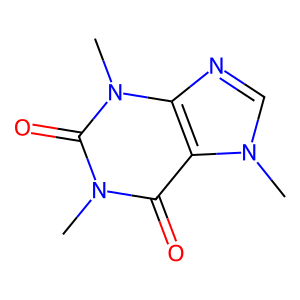


Adjacency Matrix Shape: (14, 14)
First 5x5 block:
[[0 1 0 0 0]
 [1 0 1 0 0]
 [0 1 0 1 0]
 [0 0 1 0 1]
 [0 0 0 1 0]]


In [10]:
print_section_header("Example: Caffeine Molecular Graph", "☕")

caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol = Chem.MolFromSmiles(caffeine_smiles)

print(f"Molecule: Caffeine")
print(f"SMILES: {caffeine_smiles}")
print(f"Molecular Formula: {Chem.rdMolDescriptors.CalcMolFormula(mol)}")
print(f"\nGraph Properties:")
print(f"  Number of atoms (nodes): {mol.GetNumAtoms()}")
print(f"  Number of bonds (edges): {mol.GetNumBonds()}")
print(f"  Number of rings: {Chem.rdMolDescriptors.CalcNumRings(mol)}")

# Display molecule
display(mol)

# Calculate and display adjacency matrix
from rdkit.Chem import GetAdjacencyMatrix
adj_matrix = GetAdjacencyMatrix(mol)

print(f"\nAdjacency Matrix Shape: {adj_matrix.shape}")
print("First 5x5 block:")
print(adj_matrix[:5, :5])

<a id='graph-construction'></a>
# 2. Molecular Graph Construction

**⏱️ Expected time:** 15 minutes

Now that we understand why graphs are natural for molecules, let's learn how to convert SMILES strings into graph data structures that neural networks can process.

## From SMILES to Graph

The conversion process involves three key steps:

1. **Extract atom features** → Convert each atom into a feature vector
2. **Extract bond features** → Convert each bond into a feature vector
3. **Build edge index** → Create connectivity matrix in COO format

We'll use the **OGB (Open Graph Benchmark)** featurization standard, which is widely adopted in molecular ML research.

### Atom Features

For each atom, we extract 9 categorical features:

| Feature | Description | Example Values |
|---------|-------------|----------------|
| Atomic number | Element identity | 1 (H), 6 (C), 7 (N), 8 (O) |
| Degree | Number of bonded neighbors | 0, 1, 2, 3, 4 |
| Formal charge | Integer charge | -1, 0, +1 |
| Chirality | Stereochemistry | R, S, unspecified |
| Num H atoms | Total hydrogen count | 0, 1, 2, 3 |
| Hybridization | Orbital type | sp, sp2, sp3 |
| Is aromatic | Aromaticity flag | True, False |
| Is in ring | Ring membership | True, False |

In [11]:
print_section_header("Atom Featurization (OGB Standard)", "⚛️")

# Define allowable atom features (from OGB)
ATOM_FEATURES = {
    'atomic_num': list(range(1, 119)) + ['misc'],
    'degree': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'formal_charge': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'chiral_tag': ['CHI_UNSPECIFIED', 'CHI_TETRAHEDRAL_CW', 'CHI_TETRAHEDRAL_CCW', 'CHI_OTHER'],
    'num_Hs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 'misc'],
    'hybridization': ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True]
}

def safe_index(lst, element):
    """
    Return index of element in list. If not present, return last index (misc).
    """
    try:
        return lst.index(element)
    except ValueError:
        return len(lst) - 1

def atom_to_feature_vector(atom):
    """
    Convert RDKit atom object to feature vector (list of indices).

    Args:
        atom: RDKit Atom object

    Returns:
        list: Feature vector with 8 integer indices
    """
    features = [
        safe_index(ATOM_FEATURES['atomic_num'], atom.GetAtomicNum()),
        safe_index(ATOM_FEATURES['degree'], atom.GetTotalDegree()),
        safe_index(ATOM_FEATURES['formal_charge'], atom.GetFormalCharge()),
        ATOM_FEATURES['chiral_tag'].index(str(atom.GetChiralTag())),
        safe_index(ATOM_FEATURES['num_Hs'], atom.GetTotalNumHs()),
        safe_index(ATOM_FEATURES['hybridization'], str(atom.GetHybridization())),
        ATOM_FEATURES['is_aromatic'].index(atom.GetIsAromatic()),
        ATOM_FEATURES['is_in_ring'].index(atom.IsInRing()),
    ]
    return features

# Test on ethanol
mol = Chem.MolFromSmiles('CCO')
print("Ethanol (CCO) Atom Features:")
print("-" * 50)
for i, atom in enumerate(mol.GetAtoms()):
    features = atom_to_feature_vector(atom)
    print(f"Atom {i} ({atom.GetSymbol()}):")
    print(f"  Atomic number: {atom.GetAtomicNum()}")
    print(f"  Degree: {atom.GetTotalDegree()}")
    print(f"  Hybridization: {atom.GetHybridization()}")
    print(f"  Feature vector: {features}")
    print()


⚛️  Atom Featurization (OGB Standard)

Ethanol (CCO) Atom Features:
--------------------------------------------------
Atom 0 (C):
  Atomic number: 6
  Degree: 4
  Hybridization: SP3
  Feature vector: [5, 4, 5, 0, 3, 2, 0, 0]

Atom 1 (C):
  Atomic number: 6
  Degree: 4
  Hybridization: SP3
  Feature vector: [5, 4, 5, 0, 2, 2, 0, 0]

Atom 2 (O):
  Atomic number: 8
  Degree: 2
  Hybridization: SP3
  Feature vector: [7, 2, 5, 0, 1, 2, 0, 0]



### Bond Features

For each bond, we extract 3 categorical features:

| Feature | Description | Example Values |
|---------|-------------|----------------|
| Bond type | Chemical bond order | SINGLE, DOUBLE, TRIPLE, AROMATIC |
| Stereo | Stereochemistry | E/Z, cis/trans, none |
| Conjugated | Part of conjugated system | True, False |

In [12]:
print_section_header("Bond Featurization", "🔗")

BOND_FEATURES = {
    'bond_type': ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'misc'],
    'stereo': ['STEREONONE', 'STEREOZ', 'STEREOE', 'STEREOCIS', 'STEREOTRANS', 'STEREOANY'],
    'is_conjugated': [False, True],
}

def bond_to_feature_vector(bond):
    """
    Convert RDKit bond object to feature vector.

    Args:
        bond: RDKit Bond object

    Returns:
        list: Feature vector with 3 integer indices
    """
    features = [
        safe_index(BOND_FEATURES['bond_type'], str(bond.GetBondType())),
        BOND_FEATURES['stereo'].index(str(bond.GetStereo())),
        BOND_FEATURES['is_conjugated'].index(bond.GetIsConjugated()),
    ]
    return features

# Test on ethanol bonds
mol = Chem.MolFromSmiles('CCO')
print("Ethanol Bond Features:")
print("-" * 50)
for i, bond in enumerate(mol.GetBonds()):
    features = bond_to_feature_vector(bond)
    begin = bond.GetBeginAtom().GetSymbol()
    end = bond.GetEndAtom().GetSymbol()
    bond_type = bond.GetBondType()
    print(f"Bond {i} ({begin}-{end}):")
    print(f"  Type: {bond_type}")
    print(f"  Feature vector: {features}")
    print()


🔗  Bond Featurization

Ethanol Bond Features:
--------------------------------------------------
Bond 0 (C-C):
  Type: SINGLE
  Feature vector: [0, 0, 0]

Bond 1 (C-O):
  Type: SINGLE
  Feature vector: [0, 0, 0]



### Edge Index Format (COO)

PyTorch Geometric uses **Coordinate (COO) format** for graph connectivity:

```
edge_index = [[source_nodes],
              [target_nodes]]
```

Shape: `[2, num_edges]`

**Important**: For undirected graphs (molecules), we add edges in **both directions**:
- If atom 0 bonds to atom 1, we add edges (0→1) AND (1→0)

<div align="center">
<img src="https://github.com/beangoben/chemistry_ml_colab/blob/master/images/mol_tensors.png?raw=1" width="600"/>
</div>

In [13]:
print_section_header("Complete SMILES → PyG Graph Conversion", "🔄")

def molecule_to_graph_data(smiles):
    """
    Convert SMILES to PyTorch Geometric Data object.

    Args:
        smiles: SMILES string

    Returns:
        Data: PyG Data object with x, edge_index, edge_attr
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom_to_feature_vector(atom))
    x = torch.tensor(atom_features, dtype=torch.long)

    # Edge features and edge index
    edge_indices = []
    edge_features = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_feat = bond_to_feature_vector(bond)

        # Add both directions (undirected graph)
        edge_indices.append([i, j])
        edge_features.append(bond_feat)
        edge_indices.append([j, i])
        edge_features.append(bond_feat)

    # Handle single-atom molecules (no bonds)
    if len(edge_indices) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

# Test on multiple molecules
examples = [
    ('Methane', 'C'),
    ('Ethanol', 'CCO'),
    ('Benzene', 'c1ccccc1'),
    ('Aspirin', 'CC(=O)Oc1ccccc1C(=O)O')
]

print("Molecular Graph Statistics:")
print("=" * 70)
for name, smiles in examples:
    graph = molecule_to_graph_data(smiles)
    print(f"{name:12s} | Nodes: {graph.num_nodes:3d} | Edges: {graph.num_edges:3d}")
print("=" * 70)

print("\n✓ Featurization functions ready!")
print("  - atom_to_feature_vector()")
print("  - bond_to_feature_vector()")
print("  - molecule_to_graph_data()")


🔄  Complete SMILES → PyG Graph Conversion

Molecular Graph Statistics:
Methane      | Nodes:   1 | Edges:   0
Ethanol      | Nodes:   3 | Edges:   4
Benzene      | Nodes:   6 | Edges:  12
Aspirin      | Nodes:  13 | Edges:  26

✓ Featurization functions ready!
  - atom_to_feature_vector()
  - bond_to_feature_vector()
  - molecule_to_graph_data()


<a id='dataset'></a>
# 3. The ESOL Solubility Dataset

**⏱️ Expected time:** 10 minutes

Now let's load our molecular dataset and prepare it for training.

## About ESOL

The **ESOL (Estimated SOLubility)** dataset contains:
- **1,128 molecules** with measured aqueous solubility
- **Target**: log(solubility) in mols per litre
- **SMILES** representations for each molecule

**Reference:** Delaney, J. S. (2004). ESOL: Estimating Aqueous Solubility Directly from Molecular Structure. *J. Chem. Inf. Comput. Sci.*, 44(3), 1000-1005.

### Why Solubility Matters

Aqueous solubility is a critical property in drug discovery:
- Poor solubility → Poor bioavailability
- Predicting solubility early saves time and money
- Traditional methods (wet lab) are slow and expensive

In [14]:
print_section_header("Loading ESOL Dataset", "💧")

# Load the dataset
df = pd.read_csv('data/esol.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
for col in df.columns:
    print(f"  - {col}")

# Define column names
smiles_column = 'smiles'
target_column = 'measured log solubility in mols per litre'

# Display first few rows
print(f"\nFirst 5 molecules:")
df.head()


💧  Loading ESOL Dataset

Dataset shape: (1128, 10)

Column names:
  - Compound ID
  - ESOL predicted log solubility in mols per litre
  - Minimum Degree
  - Molecular Weight
  - Number of H-Bond Donors
  - Number of Rings
  - Number of Rotatable Bonds
  - Polar Surface Area
  - measured log solubility in mols per litre
  - smiles

First 5 molecules:


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1



📊  Exploratory Data Analysis

Target Statistics:
  Mean: -3.050
  Std: 2.096
  Min: -11.600
  Max: 1.580
  Median: -2.860


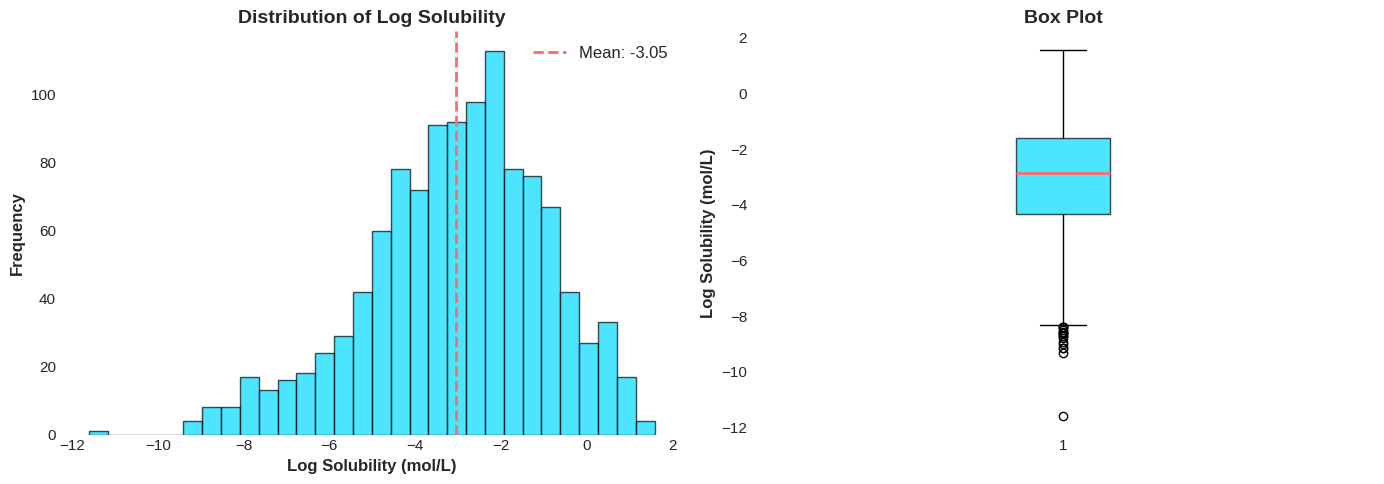


✓ Dataset loaded and explored


In [15]:
print_section_header("Exploratory Data Analysis", "📊")

# Extract target values
y = df[target_column].values

# Basic statistics
print("Target Statistics:")
print(f"  Mean: {y.mean():.3f}")
print(f"  Std: {y.std():.3f}")
print(f"  Min: {y.min():.3f}")
print(f"  Max: {y.max():.3f}")
print(f"  Median: {np.median(y):.3f}")

# Visualize distribution with Gomes colors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y, bins=30, color=GOMES_COLORS['teal'], alpha=0.7, edgecolor='black')
axes[0].axvline(y.mean(), color=GOMES_COLORS['coral'], linestyle='--', linewidth=2, label=f'Mean: {y.mean():.2f}')
axes[0].set_xlabel('Log Solubility (mol/L)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Log Solubility', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(y, vert=True, patch_artist=True,
                boxprops=dict(facecolor=GOMES_COLORS['teal'], alpha=0.7),
                medianprops=dict(color=GOMES_COLORS['coral'], linewidth=2))
axes[1].set_ylabel('Log Solubility (mol/L)', fontsize=12, fontweight='bold')
axes[1].set_title('Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Dataset loaded and explored")

In [16]:
print_section_header("Converting Molecules to Graphs", "🔄")

# Convert all SMILES to PyG graphs
smiles_list = df[smiles_column].tolist()
targets = df[target_column].values

graph_list = []
failed_indices = []

print("Converting SMILES to graphs...")
for i, smi in enumerate(tqdm(smiles_list)):
    graph = molecule_to_graph_data(smi)
    if graph is not None:
        # Add target value to graph
        graph.y = torch.tensor([targets[i]], dtype=torch.float)
        graph_list.append(graph)
    else:
        failed_indices.append(i)
        print(f"  Warning: Could not parse SMILES at index {i}: {smi}")

print(f"\n✓ Successfully converted {len(graph_list)} molecules to graphs")
print(f"  Failed: {len(failed_indices)} molecules")

# Show example graph
print(f"\nExample graph (first molecule):")
print(graph_list[0])
print(f"  Node features shape: {graph_list[0].x.shape}")
print(f"  Edge index shape: {graph_list[0].edge_index.shape}")
print(f"  Edge features shape: {graph_list[0].edge_attr.shape}")
print(f"  Target value: {graph_list[0].y.item():.3f}")


🔄  Converting Molecules to Graphs

Converting SMILES to graphs...


  0%|          | 0/1128 [00:00<?, ?it/s]


✓ Successfully converted 1128 molecules to graphs
  Failed: 0 molecules

Example graph (first molecule):
Data(x=[32, 8], edge_index=[2, 68], edge_attr=[68, 3], y=[1])
  Node features shape: torch.Size([32, 8])
  Edge index shape: torch.Size([2, 68])
  Edge features shape: torch.Size([68, 3])
  Target value: -0.770


In [17]:
print_section_header("Train/Val/Test Split (70/10/20)", "✂️")

# Create indices
n_samples = len(graph_list)
indices = list(range(n_samples))

# Split: train (70%), temp (30%)
train_idx, temp_idx = train_test_split(
    indices, test_size=0.3, random_state=RANDOM_SEED
)

# Split temp: val (10%), test (20%) -> 10/30 = 1/3, 20/30 = 2/3
val_idx, test_idx = train_test_split(
    temp_idx, test_size=2/3, random_state=RANDOM_SEED
)

print(f"Split sizes:")
print(f"  Train: {len(train_idx)} samples ({len(train_idx)/n_samples*100:.1f}%)")
print(f"  Val:   {len(val_idx)} samples ({len(val_idx)/n_samples*100:.1f}%)")
print(f"  Test:  {len(test_idx)} samples ({len(test_idx)/n_samples*100:.1f}%)")

# Create dataset lists
train_graphs = [graph_list[i] for i in train_idx]
val_graphs = [graph_list[i] for i in val_idx]
test_graphs = [graph_list[i] for i in test_idx]

# Normalize targets (critical for training!)
print(f"\nNormalizing targets...")
train_targets = np.array([g.y.item() for g in train_graphs])
scaler = StandardScaler()
scaler.fit(train_targets.reshape(-1, 1))

# Apply normalization to all graphs
for g in train_graphs:
    g.y = torch.tensor(scaler.transform([[g.y.item()]])[0], dtype=torch.float)
for g in val_graphs:
    g.y = torch.tensor(scaler.transform([[g.y.item()]])[0], dtype=torch.float)
for g in test_graphs:
    g.y = torch.tensor(scaler.transform([[g.y.item()]])[0], dtype=torch.float)

print(f"  Mean: {scaler.mean_[0]:.3f}")
print(f"  Std: {scaler.scale_[0]:.3f}")

print(f"\n✓ Data preparation complete!")


✂️  Train/Val/Test Split (70/10/20)

Split sizes:
  Train: 789 samples (69.9%)
  Val:   113 samples (10.0%)
  Test:  226 samples (20.0%)

Normalizing targets...
  Mean: -2.991
  Std: 2.075

✓ Data preparation complete!


<a id='mpnn-theory'></a>
# 4. Message-Passing Neural Networks - Theory

**⏱️ Expected time:** 15 minutes

## The Key Idea

**Message-Passing Neural Networks (MPNNs)** learn molecular representations by iteratively propagating information between connected atoms.

### How Atoms "Talk" to Each Other

Think of each atom in a molecule as a node in a communication network:
1. Each atom has a **hidden state** (feature vector)
2. Atoms **send messages** to their neighbors through bonds
3. Atoms **aggregate** messages from all neighbors
4. Atoms **update** their hidden states based on received messages
5. This process repeats for T iterations

### Mathematical Formulation

Let's formalize the message passing process:

**1. Initialization**

$$h_i^0 = I(x_i), \quad \forall i \in V$$

where $h_i^0$ is the initial hidden state of atom $i$, and $I$ is an embedding function.

**2. Message Generation** (at iteration $t+1$)

$$m_{j \rightarrow i}^{t+1} = M(h_i^t, h_j^t, e_{ij})$$

where $m_{j \rightarrow i}^{t+1}$ is the message from atom $j$ to atom $i$, and $M$ is a learnable message function that considers:
- $h_i^t$: current state of receiving atom
- $h_j^t$: current state of sending atom  
- $e_{ij}$: bond features between atoms $i$ and $j$

**3. Message Aggregation**

$$m_i^{t+1} = \sum_{j \in N(i)} m_{j \rightarrow i}^{t+1}$$

where $N(i)$ is the set of neighboring atoms of atom $i$.

**4. State Update**

$$h_i^{t+1} = U(h_i^t, m_i^{t+1})$$

where $U$ is a learnable update function (often a GRU or LSTM).

**5. Readout** (Graph-level prediction)

$$\hat{y} = R(\{h_i^T | i \in V\})$$

where $R$ is a readout function that aggregates all atom states into a single molecular representation.

### Visual Intuition: Message Passing

Let's see how information flows through a molecular graph:

<div align="center">
<img src="https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gcn_one.png?raw=1" width="600"/>
</div>

<div align="center">
<img src="https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gcn_two.png?raw=1" width="600"/>
</div>

### Multiple Iterations = Larger Receptive Field

With each message passing iteration, atoms can "see" further in the molecular graph:

- **Iteration 1**: Atoms know about immediate neighbors
- **Iteration 2**: Atoms know about neighbors-of-neighbors  
- **Iteration 3**: Atoms know about atoms 3 bonds away
- **Iteration T**: Atoms know about atoms T bonds away

<div align="center">
<img src="https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gcn_layers.png?raw=1" width="600"/>
</div>

### Connected Layers

<div align="center">
<img src="https://github.com/beangoben/chemistry_ml_colab/blob/master/images/gcn_connected.png?raw=1" width="600"/>
</div>

### Key Properties of MPNNs

1. **Permutation Invariance**: Output doesn't depend on atom ordering in the input
2. **Variable Size**: Can handle molecules with different numbers of atoms
3. **Local-to-Global**: Build molecular representations from local atomic environments
4. **Learnable**: All functions ($I$, $M$, $U$, $R$) are neural networks trained end-to-end

### Why This Works for Chemistry

- **Chemical intuition**: Molecular properties are determined by local atomic environments
- **Scalability**: Efficient on large molecules (linear in number of atoms/bonds)
- **Flexibility**: Same architecture works for different properties
- **Interpretability**: Can visualize learned representations and attention weights

<a id='mpnn-implementation'></a>
# 5. Implementing MPNN with PyTorch Geometric

**⏱️ Expected time:** 20 minutes

Now let's implement a complete MPNN using PyTorch Geometric and PyTorch Lightning!

## Architecture Overview

Our MPNN will have the following components:

1. **Atom Encoder**: Embed atom features into continuous space
2. **Bond Encoder**: Embed bond features into continuous space
3. **Message Passing Layers**: NNConv (Neural Network Convolution) with GRU updates
4. **Global Pooling**: Aggregate atom representations to molecular representation
5. **Prediction Head**: MLP to predict target property

### Why NNConv?

**NNConv** uses edge features (bond information) to modulate message passing:
- Standard GCN: Ignores bond types
- NNConv: Uses a neural network to compute edge-specific transformations
- Perfect for molecules where bond types matter!

### Why GRU?

**GRU (Gated Recurrent Unit)** for state updates:
- Handles iterative refinement of atom states
- Prevents gradient vanishing
- Learns when to keep vs. update information

In [18]:
print_section_header("MPNN Implementation", "🧠")

from torch.nn import GRU

class MPNN(pl.LightningModule):
    def __init__(
        self,
        hidden_dim,
        out_dim,
        std,
        train_data,
        valid_data,
        test_data,
        batch_size=32,
        lr=1e-3,
        num_message_passing_steps=3
    ):
        super().__init__()
        self.save_hyperparameters(ignore=['train_data', 'valid_data', 'test_data'])

        # Store dataset references
        self.std = std
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.lr = lr
        self.num_mp_steps = num_message_passing_steps

        # Initial embedding layers (from OGB)
        self.atom_emb = AtomEncoder(emb_dim=hidden_dim)
        self.bond_emb = BondEncoder(emb_dim=hidden_dim)

        # Message passing layers
        # NNConv: Neural Network Convolution with edge features
        nn_layer = MLP([hidden_dim, hidden_dim*2, hidden_dim*hidden_dim])
        self.conv = NNConv(hidden_dim, hidden_dim, nn_layer, aggr='mean')

        # GRU for node state updates
        self.gru = GRU(hidden_dim, hidden_dim)

        # Readout layer (graph-level representation)
        self.mlp = MLP([hidden_dim, int(hidden_dim/2), out_dim])

    def forward(self, data, mode="train"):
        # Initialization: embed atom and bond features
        x = self.atom_emb(data.x)  # [num_atoms, hidden_dim]
        h = x.unsqueeze(0)  # [1, num_atoms, hidden_dim] for GRU
        edge_attr = self.bond_emb(data.edge_attr)  # [num_edges, hidden_dim]

        # Message passing iterations
        for i in range(self.num_mp_steps):
            # 1. Generate and aggregate messages
            m = F.relu(self.conv(x, data.edge_index, edge_attr))

            # 2. Update node states with GRU
            x, h = self.gru(m.unsqueeze(0), h)
            x = x.squeeze(0)

        # Readout: aggregate node features to graph-level
        x = global_add_pool(x, data.batch)  # [num_graphs, hidden_dim]

        # Prediction
        x = self.mlp(x)

        return x.view(-1)

    def training_step(self, batch, batch_idx):
        out = self.forward(batch, mode="train")
        loss = F.mse_loss(out, batch.y)
        self.log("train_loss", loss, batch_size=len(batch.y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        out = self.forward(batch, mode="valid")
        # Denormalize for meaningful metrics
        loss = F.mse_loss(out * self.std, batch.y * self.std)
        self.log("val_mse", loss, batch_size=len(batch.y), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        out = self.forward(batch, mode="test")
        # Denormalize for meaningful metrics
        loss = F.mse_loss(out * self.std, batch.y * self.std)
        self.log("test_mse", loss, batch_size=len(batch.y))
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_mse'
            }
        }

    def train_dataloader(self):
        return PyGDataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return PyGDataLoader(self.valid_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return PyGDataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

print("✓ MPNN class defined")


🧠  MPNN Implementation

✓ MPNN class defined


In [19]:
print_section_header("Create Model Instance", "🏗️")

# Create model
model = MPNN(
    hidden_dim=64,
    out_dim=1,
    std=scaler.scale_[0],
    train_data=train_graphs,
    valid_data=val_graphs,
    test_data=test_graphs,
    lr=0.001,
    batch_size=32,
    num_message_passing_steps=3
)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Hidden dimension: {model.hparams.hidden_dim}")
print(f"  Message passing steps: {model.num_mp_steps}")
print(f"  Learning rate: {model.lr}")
print(f"  Batch size: {model.batch_size}")

print(f"\n✓ Ready for training!")


🏗️  Create Model Instance

Model created successfully!

Model Statistics:
  Total parameters: 580,225
  Trainable parameters: 580,225
  Hidden dimension: 64
  Message passing steps: 3
  Learning rate: 0.001
  Batch size: 32

✓ Ready for training!


<a id='training'></a>
# 6. Training and Evaluation

**⏱️ Expected time:** 5-10 minutes (depending on hardware)

Time to train our MPNN and evaluate its performance!

## Training Setup

We'll use PyTorch Lightning's Trainer with:
- **ModelCheckpoint**: Save the best model based on validation loss
- **EarlyStopping**: Stop training if validation loss doesn't improve
- **LearningRateMonitor**: Track learning rate changes
- **Optional W&B logging**: Track experiments

In [20]:
print_section_header("Setup Training", "🎯")

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_mse',
    dirpath='checkpoints',
    filename='mpnn-{epoch:02d}-{val_mse:.4f}',
    save_top_k=1,
    mode='min',
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor='val_mse',
    patience=20,
    mode='min',
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Create trainer
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    accelerator='auto',
    devices=1,
    log_every_n_steps=10,
    enable_progress_bar=True,
    deterministic=True
)

print(f"✓ Trainer configured")
print(f"  Max epochs: 100")
print(f"  Early stopping patience: 20 epochs")
print(f"  Device: {device}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



🎯  Setup Training

✓ Trainer configured
  Max epochs: 100
  Early stopping patience: 20 epochs
  Device: cuda


In [21]:
print_section_header("Training MPNN", "🚀")

print(f"Starting training...\n")
print(estimate_runtime(torch.cuda.is_available()))
print()

# Train model
trainer.fit(model)

print(f"\n✓ Training complete!")

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision



🚀  Training MPNN

Starting training...

⏱️ Expected runtime: ~2-3 minutes (GPU)



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type        | Params
-----------------------------------------
0 | atom_emb | AtomEncoder | 11.1 K
1 | bond_emb | BondEncoder | 832   
2 | conv     | NNConv      | 541 K 
3 | gru      | GRU         | 25.0 K
4 | mlp      | MLP         | 2.2 K 
-----------------------------------------
580 K     Trainable params
0         Non-trainable params
580 K     Total params
2.321     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved. New best score: 2.546
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 25: 'val_mse' reached 2.54642 (best 2.54642), saving model to 'checkpoints/mpnn-epoch=00-val_mse=2.5464.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.732 >= min_delta = 0.0. New best score: 1.815
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 50: 'val_mse' reached 1.81470 (best 1.81470), saving model to 'checkpoints/mpnn-epoch=01-val_mse=1.8147.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.563 >= min_delta = 0.0. New best score: 1.251
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 75: 'val_mse' reached 1.25126 (best 1.25126), saving model to 'checkpoints/mpnn-epoch=02-val_mse=1.2513.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 100: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 125: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 150: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.426 >= min_delta = 0.0. New best score: 0.826
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 175: 'val_mse' reached 0.82553 (best 0.82553), saving model to 'checkpoints/mpnn-epoch=06-val_mse=0.8255.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.114 >= min_delta = 0.0. New best score: 0.712
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 200: 'val_mse' reached 0.71178 (best 0.71178), saving model to 'checkpoints/mpnn-epoch=07-val_mse=0.7118.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.010 >= min_delta = 0.0. New best score: 0.702
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 225: 'val_mse' reached 0.70153 (best 0.70153), saving model to 'checkpoints/mpnn-epoch=08-val_mse=0.7015.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.077 >= min_delta = 0.0. New best score: 0.624
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 250: 'val_mse' reached 0.62421 (best 0.62421), saving model to 'checkpoints/mpnn-epoch=09-val_mse=0.6242.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 275: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.048 >= min_delta = 0.0. New best score: 0.577
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 300: 'val_mse' reached 0.57671 (best 0.57671), saving model to 'checkpoints/mpnn-epoch=11-val_mse=0.5767.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.083 >= min_delta = 0.0. New best score: 0.494
INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 325: 'val_mse' reached 0.49391 (best 0.49391), saving model to 'checkpoints/mpnn-epoch=12-val_mse=0.4939.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 350: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 375: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.022 >= min_delta = 0.0. New best score: 0.472
INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 400: 'val_mse' reached 0.47215 (best 0.47215), saving model to 'checkpoints/mpnn-epoch=15-val_mse=0.4721.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 425: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 450: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 475: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 500: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.044 >= min_delta = 0.0. New best score: 0.429
INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 525: 'val_mse' reached 0.42851 (best 0.42851), saving model to 'checkpoints/mpnn-epoch=20-val_mse=0.4285.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 550: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 575: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.080 >= min_delta = 0.0. New best score: 0.349
INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 600: 'val_mse' reached 0.34864 (best 0.34864), saving model to 'checkpoints/mpnn-epoch=23-val_mse=0.3486.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 625: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 650: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 675: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 700: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 725: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 750: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 775: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 800: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 825: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 850: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 875: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 900: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 925: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 950: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.003 >= min_delta = 0.0. New best score: 0.345
INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 975: 'val_mse' reached 0.34536 (best 0.34536), saving model to 'checkpoints/mpnn-epoch=38-val_mse=0.3454.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.002 >= min_delta = 0.0. New best score: 0.343
INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 1000: 'val_mse' reached 0.34350 (best 0.34350), saving model to 'checkpoints/mpnn-epoch=39-val_mse=0.3435.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_mse improved by 0.007 >= min_delta = 0.0. New best score: 0.337
INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 1025: 'val_mse' reached 0.33691 (best 0.33691), saving model to 'checkpoints/mpnn-epoch=40-val_mse=0.3369.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 1050: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 1075: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 1100: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 1125: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 1150: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 1175: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 1200: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 1225: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 1250: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 1275: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 1300: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 1325: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 1350: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 1375: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 1400: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 1425: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 1450: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 1475: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 1500: 'val_mse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_mse did not improve in the last 20 records. Best score: 0.337. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 1525: 'val_mse' was not in top 1



✓ Training complete!


In [24]:
print_section_header("Test Set Evaluation", "📈")

# Test the best model
# Fix for PyTorch 2.6+ security restriction: Load best checkpoint manually with weights_only=False
best_path = trainer.checkpoint_callback.best_model_path
if best_path:
    print(f"Loading best model from: {best_path}")
    checkpoint = torch.load(best_path, weights_only=False)
    model.load_state_dict(checkpoint["state_dict"])
    test_results = trainer.test(model, ckpt_path=None)
else:
    print("Warning: No best checkpoint found. Testing with current model weights.")
    test_results = trainer.test(model)

# Get predictions on test set
# Ensure model is on the correct device before inference
model = model.to(device)
model.eval()
test_loader = PyGDataLoader(test_graphs, batch_size=64, shuffle=False)

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        preds = model(batch)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(batch.y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

# Denormalize predictions
y_pred_denorm = y_pred * scaler.scale_[0] + scaler.mean_[0]
y_true_denorm = y_true * scaler.scale_[0] + scaler.mean_[0]

# Calculate metrics
r2 = r2_score(y_true_denorm, y_pred_denorm)
rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
mae = mean_absolute_error(y_true_denorm, y_pred_denorm)

metrics = {
    "R² Score": r2,
    "RMSE": rmse,
    "MAE": mae
}

print_metrics(metrics, "Test Set Performance")

print(f"\n✓ Model achieves R² = {r2:.4f} on test set!")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📈  Test Set Evaluation

Loading best model from: checkpoints/mpnn-epoch=40-val_mse=0.3369.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │    0.46763521432876587    │
└───────────────────────────┴───────────────────────────┘


Test Set Performance:
----------------------------------------
  R² Score...................... 0.8895
  RMSE.......................... 0.6838
  MAE........................... 0.4731
----------------------------------------

✓ Model achieves R² = 0.8895 on test set!



📊  Visualize Results



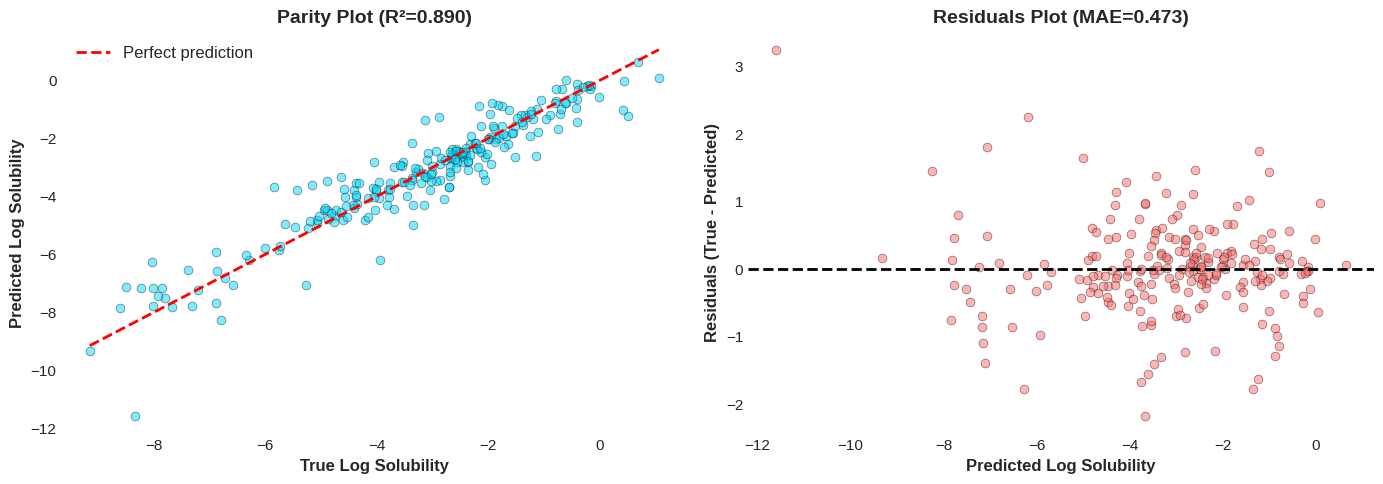

✓ The model shows good predictive performance!
  - Points close to diagonal line = good predictions
  - Residuals centered around 0 = unbiased predictions


In [25]:
print_section_header("Visualize Results", "📊")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Parity plot
axes[0].scatter(y_true_denorm, y_pred_denorm, alpha=0.5, c=GOMES_COLORS['teal'], s=40, edgecolors='k', linewidth=0.5)
axes[0].plot([y_true_denorm.min(), y_true_denorm.max()],
             [y_true_denorm.min(), y_true_denorm.max()],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True Log Solubility', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Log Solubility', fontsize=12, fontweight='bold')
axes[0].set_title(f'Parity Plot (R²={r2:.3f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_true_denorm - y_pred_denorm
axes[1].scatter(y_pred_denorm, residuals, alpha=0.5, c=GOMES_COLORS['coral'], s=40, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='k', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Log Solubility', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (True - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Residuals Plot (MAE={mae:.3f})', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ The model shows good predictive performance!")
print("  - Points close to diagonal line = good predictions")
print("  - Residuals centered around 0 = unbiased predictions")

<a id='representations'></a>
# 7. Understanding Learned Representations

**⏱️ Expected time:** 5 minutes

Let's visualize what the GNN has learned by extracting and analyzing molecular embeddings!

## What are Embeddings?

Before making predictions, our MPNN creates a **fixed-size vector representation** for each molecule. These embeddings encode chemical information learned during training.

We'll use **PCA (Principal Component Analysis)** to project high-dimensional embeddings to 2D for visualization.

In [26]:
print_section_header("Extract Graph Embeddings", "🎨")

# Modify forward pass to return embeddings
def forward_with_embedding(model, data):
    """Modified forward pass that returns both prediction and embedding"""
    # Initialization
    x = model.atom_emb(data.x)
    h = x.unsqueeze(0)
    edge_attr = model.bond_emb(data.edge_attr)

    # Message passing
    for i in range(model.num_mp_steps):
        m = F.relu(model.conv(x, data.edge_index, edge_attr))
        x, h = model.gru(m.unsqueeze(0), h)
        x = x.squeeze(0)

    # Readout - this is our embedding!
    embedding = global_add_pool(x, data.batch)

    # Prediction
    pred = model.mlp(embedding)

    return pred.view(-1), embedding

# Extract embeddings for all molecules
model.eval()
all_loader = PyGDataLoader(graph_list, batch_size=64, shuffle=False)

all_embeddings = []
all_targets = []

print("Extracting embeddings...")
with torch.no_grad():
    for batch in tqdm(all_loader):
        batch = batch.to(device)
        _, embeddings = forward_with_embedding(model, batch)
        all_embeddings.append(embeddings.cpu().numpy())
        # Denormalize targets for visualization
        targets_denorm = batch.y.cpu().numpy() * scaler.scale_[0] + scaler.mean_[0]
        all_targets.append(targets_denorm)

embeddings = np.concatenate(all_embeddings, axis=0)
targets = np.concatenate(all_targets, axis=0)

print(f"\n✓ Extracted embeddings")
print(f"  Shape: {embeddings.shape}")
print(f"  Embedding dimension: {embeddings.shape[1]}")


🎨  Extract Graph Embeddings

Extracting embeddings...


  0%|          | 0/18 [00:00<?, ?it/s]


✓ Extracted embeddings
  Shape: (1128, 64)
  Embedding dimension: 64



🔍  PCA Visualization

PCA Results:
  PC1 explains 27.04% of variance
  PC2 explains 23.46% of variance
  Total explained: 50.50%


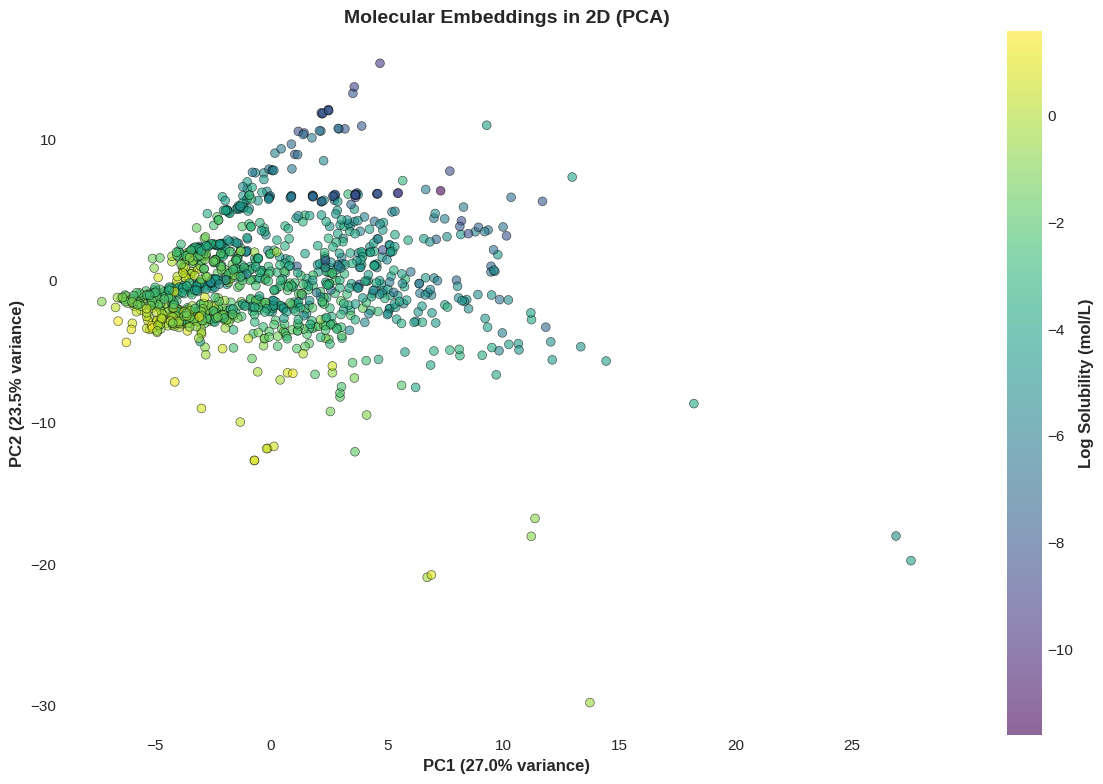


✓ Embedding Visualization Complete!

Key Observations:
  - Similar molecules cluster together
  - Color gradient shows solubility patterns
  - GNN learned chemically meaningful representations!


In [27]:
print_section_header("PCA Visualization", "🔍")

# Standardize embeddings before PCA
from sklearn.preprocessing import StandardScaler as Scaler
emb_scaler = Scaler()
embeddings_scaled = emb_scaler.fit_transform(embeddings)

# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_scaled)

print(f"PCA Results:")
print(f"  PC1 explains {pca.explained_variance_ratio_[0]:.2%} of variance")
print(f"  PC2 explains {pca.explained_variance_ratio_[1]:.2%} of variance")
print(f"  Total explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=targets,
    cmap='viridis',
    s=40,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
              fontsize=12, fontweight='bold')
ax.set_title('Molecular Embeddings in 2D (PCA)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Log Solubility (mol/L)', fontsize=12, fontweight='bold')

ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n✓ Embedding Visualization Complete!")
print("\nKey Observations:")
print("  - Similar molecules cluster together")
print("  - Color gradient shows solubility patterns")
print("  - GNN learned chemically meaningful representations!")

<a id='chemprop'></a>
# 8. Chemprop - Production-Ready GNNs

**⏱️ Expected time:** 10 minutes

While building custom GNNs is educational, in production you often want battle-tested tools. Enter **Chemprop**!

## What is Chemprop?

**Chemprop** is a production-ready molecular property prediction framework developed at MIT:
- **Optimized D-MPNN**: Directed message passing with extensive hyperparameter tuning
- **Easy CLI**: Train models with a single command
- **Uncertainty quantification**: Built-in ensemble and dropout methods
- **Transfer learning**: Pre-trained models for low-data scenarios
- **Well-tested**: Used in numerous drug discovery projects

**Reference:** Yang et al. (2019). Analyzing Learned Molecular Representations for Property Prediction. *J. Chem. Inf. Model.*

### When to Use Custom GNNs vs. Chemprop?

**Custom GNNs (like our MPNN)**:
- Research and experimentation
- Novel architectures
- Custom featurization
- Learning and teaching

**Chemprop**:
- Production deployments
- Quick baselines
- Limited ML expertise
- Proven reliability needed

In [28]:
print_section_header("Chemprop Training", "⚡")

print("Chemprop v2.2.1 CLI Training")
print("="*70)
print()
print("Basic training command:")
print()
print("  !chemprop train \\")
print("      --data-path data/esol.csv \\")
print("      --task-type regression \\")
print("      --output-dir chemprop_output \\")
print("      --epochs 50 \\")
print("      --batch-size 50 \\")
print("      --split-type random \\")
print("      --split-sizes 0.7 0.1 0.2")
print()
print("Prediction command:")
print()
print("  !chemprop predict \\")
print("      --model-path chemprop_output/model.pt \\")
print("      --data-path test.csv \\")
print("      --output-path predictions.csv")
print()
print("="*70)
print()
print("Note: Chemprop training is commented out to keep notebook runtime short.")
print("Uncomment the commands above to train a Chemprop model!")
print()
print("Expected performance: R² ~ 0.90-0.92 (slightly better than our MPNN)")


⚡  Chemprop Training

Chemprop v2.2.1 CLI Training

Basic training command:

  !chemprop train \
      --data-path data/esol.csv \
      --task-type regression \
      --output-dir chemprop_output \
      --epochs 50 \
      --batch-size 50 \
      --split-type random \
      --split-sizes 0.7 0.1 0.2

Prediction command:

  !chemprop predict \
      --model-path chemprop_output/model.pt \
      --data-path test.csv \
      --output-path predictions.csv


Note: Chemprop training is commented out to keep notebook runtime short.
Uncomment the commands above to train a Chemprop model!

Expected performance: R² ~ 0.90-0.92 (slightly better than our MPNN)


### Chemprop Advanced Features

**Ensemble Models**:
```bash
chemprop train \
    --data-path data/esol.csv \
    --ensemble-size 5  # Train 5 models for uncertainty
```

**Hyperparameter Optimization**:
```bash
chemprop hyper opt\
    --data-path data/esol.csv \
    --num-iters 20
```

**Transfer Learning**:
```bash
chemprop train \
    --data-path small_dataset.csv \
    --checkpoint-path pretrained_model.pt  # Fine-tune
```

**Interpretability**:
```bash
chemprop interpret \
    --model-path model.pt \
    --data-path molecules.csv
```

<a id='debugging'></a>
# 9. Common Pitfalls and Debugging

**⏱️ Expected time:** 5 minutes

GNN training can be tricky! Here are common issues and solutions.

## Issue 1: GPU Not Detected

**Symptom**: Model trains on CPU (very slow)

**Solution**:
1. In Colab: Runtime → Change runtime type → Hardware accelerator → GPU
2. Check `torch.cuda.is_available()` returns `True`
3. Restart runtime if needed

## Issue 2: CUDA Out of Memory

**Symptom**: `RuntimeError: CUDA out of memory`

**Solutions**:
```python
# 1. Reduce batch size
model = MPNN(..., batch_size=16)  # Instead of 32

# 2. Reduce model size
model = MPNN(hidden_dim=32, ...)  # Instead of 64

# 3. Use gradient accumulation
trainer = pl.Trainer(accumulate_grad_batches=2)
```

## Issue 3: Model Not Learning (High Loss)

**Symptom**: Validation loss stays constant or very high

**Solutions**:
```python
# 1. Check target normalization
print(f"Target mean: {y_train.mean()}, std: {y_train.std()}")
# Should be close to 0 and 1 after normalization

# 2. Increase learning rate
model = MPNN(..., lr=0.01)  # Try 10x higher

# 3. Check for NaN values
print(f"NaN in data: {torch.isnan(batch.y).sum()}")
```

## Issue 4: Overfitting

**Symptom**: Train loss << validation loss

**Solutions**:
```python
# 1. Add dropout
self.dropout = nn.Dropout(0.2)

# 2. Reduce model capacity
model = MPNN(hidden_dim=32, num_message_passing_steps=2)

# 3. Use weight decay
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=1e-5)

# 4. More data augmentation
# SMILES enumeration, scaffold splitting, etc.
```

## Issue 5: Slow Training

**Solutions**:
```python
# 1. Use DataLoader num_workers
loader = PyGDataLoader(dataset, batch_size=32, num_workers=4)

# 2. Mixed precision training
trainer = pl.Trainer(precision='16-mixed')

# 3. Compile model (PyTorch 2.0+)
model = torch.compile(model)
```

In [29]:
print_section_header("Debugging Checklist", "🔧")

print("Run this cell to check your setup:\n")

# 1. Device check
print(f"1. Device: {device}")
if torch.cuda.is_available():
    print(f"   ✓ GPU available")
else:
    print(f"   ⚠️  CPU only (training will be slow)")

# 2. Data check
print(f"\n2. Data:")
print(f"   Train samples: {len(train_graphs)}")
print(f"   Val samples: {len(val_graphs)}")
print(f"   Test samples: {len(test_graphs)}")

# 3. Normalization check
train_targets_norm = np.array([g.y.item() for g in train_graphs])
print(f"\n3. Target normalization:")
print(f"   Mean: {train_targets_norm.mean():.3f} (should be ~0)")
print(f"   Std: {train_targets_norm.std():.3f} (should be ~1)")
if abs(train_targets_norm.mean()) < 0.1 and abs(train_targets_norm.std() - 1) < 0.1:
    print(f"   ✓ Targets properly normalized")
else:
    print(f"   ⚠️  Check normalization!")

# 4. Model check
print(f"\n4. Model:")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Device: {next(model.parameters()).device}")

# 5. Batch check
print(f"\n5. Data loading:")
test_loader = PyGDataLoader(train_graphs[:10], batch_size=5)
test_batch = next(iter(test_loader))
print(f"   Batch size: {test_batch.num_graphs}")
print(f"   Total nodes: {test_batch.num_nodes}")
print(f"   Total edges: {test_batch.num_edges}")
print(f"   ✓ DataLoader working")

print(f"\n✓ All checks passed!")


🔧  Debugging Checklist

Run this cell to check your setup:

1. Device: cuda
   ✓ GPU available

2. Data:
   Train samples: 789
   Val samples: 113
   Test samples: 226

3. Target normalization:
   Mean: 0.000 (should be ~0)
   Std: 1.000 (should be ~1)
   ✓ Targets properly normalized

4. Model:
   Parameters: 580,225
   Device: cuda:0

5. Data loading:
   Batch size: 5
   Total nodes: 86
   Total edges: 186
   ✓ DataLoader working

✓ All checks passed!


<a id='extensions'></a>
# 10. Extensions and Next Steps

**⏱️ Expected time:** 15-20 minutes (optional advanced topics)

Congratulations on completing the core tutorial! Here are directions for further exploration.

## 10.1 Advanced GNN Architectures

### Graph Attention Networks (GAT)
- Learn attention weights for neighbor aggregation
- More interpretable than standard MPNNs
- Implementation: `from torch_geometric.nn import GATConv`

### Graph Isomorphism Networks (GIN)
- Maximally expressive GNN architecture
- Theoretical guarantees on distinguishing graphs
- Implementation: `from torch_geometric.nn import GINConv`

### Equivariant GNNs (E(3)-GNN, SchNet, DimeNet)
- Incorporate 3D molecular geometry
- Respect physical symmetries
- Better for quantum properties

## 10.2 Hyperparameter Optimization

Use Bayesian Optimization to find best hyperparameters:
```python
from bayes_opt import BayesianOptimization

def train_and_evaluate(hidden_dim, lr, num_mp_steps):
    model = MPNN(
        hidden_dim=int(hidden_dim),
        lr=lr,
        num_message_passing_steps=int(num_mp_steps),
        ...
    )
    trainer = pl.Trainer(max_epochs=30)
    trainer.fit(model)
    results = trainer.test(model)
    return -results[0]['test_mse']  # Negative because we maximize

optimizer = BayesianOptimization(
    f=train_and_evaluate,
    pbounds={
        'hidden_dim': (32, 128),
        'lr': (0.0001, 0.01),
        'num_mp_steps': (2, 5)
    }
)

optimizer.maximize(n_iter=20)
```

## 10.3 Uncertainty Quantification

### Ensemble Methods
Train multiple models with different initializations:
```python
ensemble = []
for i in range(5):
    set_seed(42 + i)
    model = MPNN(...)
    trainer.fit(model)
    ensemble.append(model)

# Predict with ensemble
predictions = [model(batch) for model in ensemble]
mean_pred = torch.stack(predictions).mean(dim=0)
std_pred = torch.stack(predictions).std(dim=0)  # Uncertainty!
```

### MC Dropout
Enable dropout during inference:
```python
def predict_with_uncertainty(model, batch, n_samples=50):
    model.train()  # Enable dropout
    predictions = [model(batch) for _ in range(n_samples)]
    model.eval()
    return torch.stack(predictions).mean(dim=0), torch.stack(predictions).std(dim=0)
```

## 10.6 Model Explainability with Captum

**Understanding WHY your GNN makes specific predictions**

While achieving high predictive accuracy is important, understanding *why* a model makes certain predictions is equally crucial in drug discovery and molecular design. This section demonstrates how to use **Captum** and **PyTorch Geometric's explainability tools** to identify which atoms and bonds are most important for predictions.

### Why Explainability Matters in Chemistry

- **Trust**: Validate that the model learns chemically meaningful patterns
- **Discovery**: Identify key structural motifs responsible for properties
- **Safety**: Detect when models rely on spurious correlations
- **Design**: Guide molecular optimization by understanding structure-activity relationships

### Explainability Approaches

We'll cover three complementary methods:

1. **Saliency Maps**: Gradient-based attribution showing which features matter
2. **Integrated Gradients**: More robust gradient-based method with theoretical guarantees
3. **Visual Analysis**: Mapping attributions back to molecular structures

### Recent Research

Recent studies (2024-2025) have shown that combining Captum's Integrated Gradients with GNN-specific explainers improves both accuracy and interpretability in drug discovery applications [[Nature Scientific Reports, 2024](https://www.nature.com/articles/s41598-024-83090-3)].

**Learning Objectives:**
- Install and configure Captum for graph neural networks
- Compute atom and bond importance scores
- Visualize explanations on molecular structures
- Validate explanations against chemical intuition

In [30]:
print_section_header("Installing Captum for GNN Explainability", "🔍")

# Install Captum if not already installed
try:
    import captum
    print(f"✓ Captum already installed (version {captum.__version__})")
except ImportError:
    print("Installing Captum...")
    !uv pip install -q captum
    import captum
    print(f"✓ Captum installed (version {captum.__version__})")

# Import explainability modules
from captum.attr import Saliency, IntegratedGradients
import networkx as nx
from collections import defaultdict

print("\n✓ Explainability tools ready!")
print("  - Saliency: Fast gradient-based attribution")
print("  - IntegratedGradients: Robust attribution with theoretical guarantees")


🔍  Installing Captum for GNN Explainability

Installing Captum...
✓ Captum installed (version 0.8.0)

✓ Explainability tools ready!
  - Saliency: Fast gradient-based attribution
  - IntegratedGradients: Robust attribution with theoretical guarantees


### Theory: Feature Attribution for GNNs

**Goal**: For a given prediction $\hat{y} = f(G)$, determine the importance of each edge (bond) in the molecular graph $G$.

#### Method 1: Saliency (Gradient-Based Attribution)

The **Saliency method** uses the gradient of the model output with respect to edge weights:

$$
\text{Attribution}_{e_i} = \left| \frac{\partial f(G)}{\partial w_{e_i}} \right|
$$

Where:
- $f(G)$ is the GNN prediction for graph $G$
- $w_{e_i}$ is the weight of edge $e_i$ (initially 1.0 for all edges)
- The absolute value gives us the magnitude of importance

**Intuition**: If a small change in edge $e_i$ causes a large change in the prediction, that edge is important.

#### Method 2: Integrated Gradients

**Integrated Gradients** is more robust, accumulating gradients along a path from a baseline to the actual input:

$$
\text{Attribution}_{e_i} = (w_{e_i} - w_{e_i}^{\text{baseline}}) \times \int_{\alpha=0}^{1} \frac{\partial f(G_{\alpha})}{\partial w_{e_i}} d\alpha
$$

Where:
- $G_{\alpha}$ is a graph with edge weights interpolated: $w_{e_i}^{\alpha} = w_{e_i}^{\text{baseline}} + \alpha \cdot (w_{e_i} - w_{e_i}^{\text{baseline}})$
- Baseline: graph with all edge weights = 0 (no edges)
- Actual input: graph with all edge weights = 1 (all edges present)
- The integral is approximated using $n$ discrete steps

**Advantages of Integrated Gradients:**
- **Axiom 1 (Completeness)**: Attributions sum to difference between baseline and prediction
- **Axiom 2 (Sensitivity)**: If a feature affects output, it gets non-zero attribution
- More stable than vanilla gradients, less susceptible to saturation

**Reference**: [Sundararajan et al. (2017). Axiomatic Attribution for Deep Networks. ICML.](https://arxiv.org/abs/1703.01365)

#### PyTorch Geometric + Captum Integration

PyTorch Geometric (v2.6+) provides native integration with Captum through:
- `CaptumExplainer`: Wrapper for Captum attribution methods
- `to_captum_model`: Converts PyG models to Captum-compatible format
- Supports both homogeneous and heterogeneous graphs

For molecular graphs, we'll create custom wrapper functions that:
1. Convert edge weights into learnable parameters
2. Forward pass through the GNN with edge weight masking
3. Compute gradients with respect to edge weights
4. Return attributions for each bond

In [31]:
print_section_header("Implementing GNN Explainability Functions", "🛠️")

def model_forward_for_explainability(edge_mask, data, model, target_idx=0):
    """
    Forward pass through the model with edge masking for explainability.

    Args:
        edge_mask: Tensor of shape [num_edges] representing edge importance weights
        data: PyG Data object containing molecular graph
        model: Trained GNN model
        target_idx: Index of target (0 for regression, class index for classification)

    Returns:
        Output prediction (scalar for regression)
    """
    # Create batch tensor for single molecule
    batch = torch.zeros(data.x.shape[0], dtype=torch.long, device=data.x.device)

    # Create a modified data object with edge weights
    data_masked = data.clone()

    # For our MPNN model, we need to handle edge masking
    # We'll weight the edge features by the mask
    if hasattr(data_masked, 'edge_attr') and data_masked.edge_attr is not None:
        # Expand edge_mask to match edge_attr dimensions
        edge_mask_expanded = edge_mask.unsqueeze(1).expand_as(
            model.bond_emb(data_masked.edge_attr)
        )

    # Forward pass with custom edge masking
    x = model.atom_emb(data_masked.x)
    h = x.unsqueeze(0)
    edge_attr = model.bond_emb(data_masked.edge_attr)

    # Apply edge masking to edge features
    if hasattr(data_masked, 'edge_attr') and data_masked.edge_attr is not None:
        edge_attr = edge_attr * edge_mask.unsqueeze(1)

    # Message passing with masked edges
    for i in range(model.num_mp_steps):
        m = F.relu(model.conv(x, data_masked.edge_index, edge_attr))
        x, h = model.gru(m.unsqueeze(0), h)
        x = x.squeeze(0)

    # Readout
    x = global_add_pool(x, batch)
    out = model.mlp(x)

    return out.squeeze()


def explain_molecule(
    data,
    model,
    method='integrated_gradients',
    n_steps=50,
    device='cpu'
):
    """
    Explain a molecular graph prediction using Captum.

    Args:
        data: PyG Data object (single molecule)
        model: Trained GNN model
        method: 'saliency' or 'integrated_gradients'
        n_steps: Number of integration steps (for IG)
        device: Device to run on

    Returns:
        edge_attributions: Numpy array of shape [num_edges] with importance scores
    """
    model.eval()
    data = data.to(device)

    # Create edge mask (all edges present initially)
    num_edges = data.edge_index.shape[1]
    edge_mask = torch.ones(num_edges, requires_grad=True, device=device)

    # Wrap model forward function
    def forward_func(edge_mask):
        return model_forward_for_explainability(edge_mask, data, model)

    # Compute attributions
    if method == 'saliency':
        explainer = Saliency(forward_func)
        attributions = explainer.attribute(edge_mask, abs=True)
    elif method == 'integrated_gradients':
        # Baseline: no edges (edge_mask = 0)
        baseline = torch.zeros_like(edge_mask)
        explainer = IntegratedGradients(forward_func)
        attributions = explainer.attribute(
            edge_mask,
            baselines=baseline,
            n_steps=n_steps
        )
    else:
        raise ValueError(f"Unknown method: {method}")

    # Convert to numpy and normalize
    attr = attributions.detach().cpu().numpy()
    attr = np.abs(attr)

    # Normalize to [0, 1]
    if attr.max() > 0:
        attr = attr / attr.max()

    return attr


print("✓ Explainability functions defined:")
print("  - model_forward_for_explainability(): Forward pass with edge masking")
print("  - explain_molecule(): Compute attributions using Captum")


🛠️  Implementing GNN Explainability Functions

✓ Explainability functions defined:
  - model_forward_for_explainability(): Forward pass with edge masking
  - explain_molecule(): Compute attributions using Captum


In [32]:
print_section_header("Molecular Visualization with Attributions", "🎨")

def aggregate_edge_directions(edge_attributions, data):
    """
    Aggregate attributions for undirected edges (molecular graphs).
    Since we add edges in both directions, average the attributions.

    Args:
        edge_attributions: Array of shape [num_edges] with attributions
        data: PyG Data object

    Returns:
        dict: {(u, v): attribution} where u < v (undirected edges)
    """
    edge_dict = defaultdict(list)

    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        # Make undirected: always use (min, max) order
        edge_key = (min(u, v), max(u, v))
        edge_dict[edge_key].append(edge_attributions[i])

    # Average attributions for both directions
    aggregated = {k: np.mean(v) for k, v in edge_dict.items()}
    return aggregated


def draw_molecule_with_attributions(
    smiles,
    edge_attributions_dict,
    title="Molecular Attribution Map",
    figsize=(12, 8)
):
    """
    Draw molecule with edges colored by attribution scores.

    Args:
        smiles: SMILES string
        edge_attributions_dict: {(u, v): attribution_score}
        title: Plot title
        figsize: Figure size
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Could not parse SMILES: {smiles}")
        return

    # Create NetworkX graph
    G = nx.Graph()

    # Add nodes with atom labels
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), label=atom.GetSymbol())

    # Add edges
    for bond in mol.GetBonds():
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        G.add_edge(u, v)

    # Generate layout
    pos = nx.spring_layout(G, seed=42, iterations=50)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Draw nodes
    node_colors = [GOMES_COLORS['navy']] * len(G.nodes())
    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=600,
        ax=ax,
        alpha=0.9
    )

    # Draw node labels
    labels = {n: G.nodes[n]['label'] for n in G.nodes()}
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=12,
        font_color='white',
        font_weight='bold',
        ax=ax
    )

    # Draw edges with attribution-based coloring
    edge_colors = []
    edge_widths = []

    for (u, v) in G.edges():
        edge_key = (min(u, v), max(u, v))
        attr = edge_attributions_dict.get(edge_key, 0.0)
        edge_colors.append(attr)
        edge_widths.append(1 + 8 * attr)  # Width proportional to importance

    edges = nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        edge_cmap=plt.cm.Reds,
        edge_vmin=0,
        edge_vmax=1,
        ax=ax,
        alpha=0.8
    )

    # Add colorbar
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.Reds,
        norm=plt.Normalize(vmin=0, vmax=1)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Edge Importance', fontsize=12, fontweight='bold')

    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


print("✓ Visualization functions ready:")
print("  - aggregate_edge_directions(): Merge bidirectional edges")
print("  - draw_molecule_with_attributions(): Visualize importance on structure")


🎨  Molecular Visualization with Attributions

✓ Visualization functions ready:
  - aggregate_edge_directions(): Merge bidirectional edges
  - draw_molecule_with_attributions(): Visualize importance on structure



🧪  Select Example Molecules for Explanation

Selected molecules for explanation:

1. Low solubility
   SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCC
   True:      -8.334 log(mol/L)
   Predicted: -11.588 log(mol/L)

2. Medium solubility
   SMILES: CCCCCC#C
   True:      -3.010 log(mol/L)
   Predicted: -2.931 log(mol/L)

3. High solubility
   SMILES: OCC(O)C(O)CO
   True:      0.700 log(mol/L)
   Predicted: 0.640 log(mol/L)

Molecular structures:


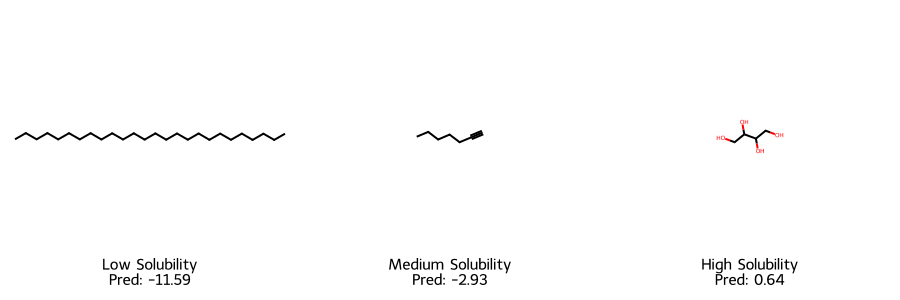

In [33]:
print_section_header("Select Example Molecules for Explanation", "🧪")

# Get examples with different predicted solubilities
# High solubility, medium, and low

model.eval()
model = model.to(device)

# Get predictions for test set
test_predictions = []
test_smiles = []

for idx in test_idx:
    graph = graph_list[idx]
    smiles = df.iloc[idx][smiles_column]

    # Get prediction
    graph_device = graph.clone().to(device)
    with torch.no_grad():
        pred = model(graph_device).cpu().item()
        # Denormalize
        pred_denorm = pred * scaler.scale_[0] + scaler.mean_[0]

    test_predictions.append(pred_denorm)
    test_smiles.append((idx, smiles, pred_denorm))

# Sort by prediction
test_smiles.sort(key=lambda x: x[2])

# Select examples: low, medium, high solubility
examples_to_explain = [
    test_smiles[0],  # Lowest predicted solubility
    test_smiles[len(test_smiles)//2],  # Medium
    test_smiles[-1],  # Highest predicted solubility
]

print("Selected molecules for explanation:\n")
for i, (idx, smiles, pred) in enumerate(examples_to_explain):
    true_val = df.iloc[idx][target_column]
    print(f"{i+1}. Low solubility" if i == 0 else f"{i+1}. Medium solubility" if i == 1 else f"{i+1}. High solubility")
    print(f"   SMILES: {smiles}")
    print(f"   True:      {true_val:.3f} log(mol/L)")
    print(f"   Predicted: {pred:.3f} log(mol/L)")
    print()

# Display structures
print("Molecular structures:")
mols = [Chem.MolFromSmiles(x[1]) for x in examples_to_explain]
legends = [f"Low Solubility\nPred: {examples_to_explain[0][2]:.2f}",
           f"Medium Solubility\nPred: {examples_to_explain[1][2]:.2f}",
           f"High Solubility\nPred: {examples_to_explain[2][2]:.2f}"]

img = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(300, 300),
    legends=legends
)
display(img)


📊  Method 1: Saliency-Based Explanations

Computing saliency maps for example molecules...


Example 1: Low Solubility Molecule
Computing saliency attributions...

Top 5 most important bonds:
  1. Bond 0-1 (C-C): 0.6015
  2. Bond 24-25 (C-C): 0.6015
  3. Bond 1-2 (C-C): 0.2495
  4. Bond 23-24 (C-C): 0.2495
  5. Bond 2-3 (C-C): 0.1698


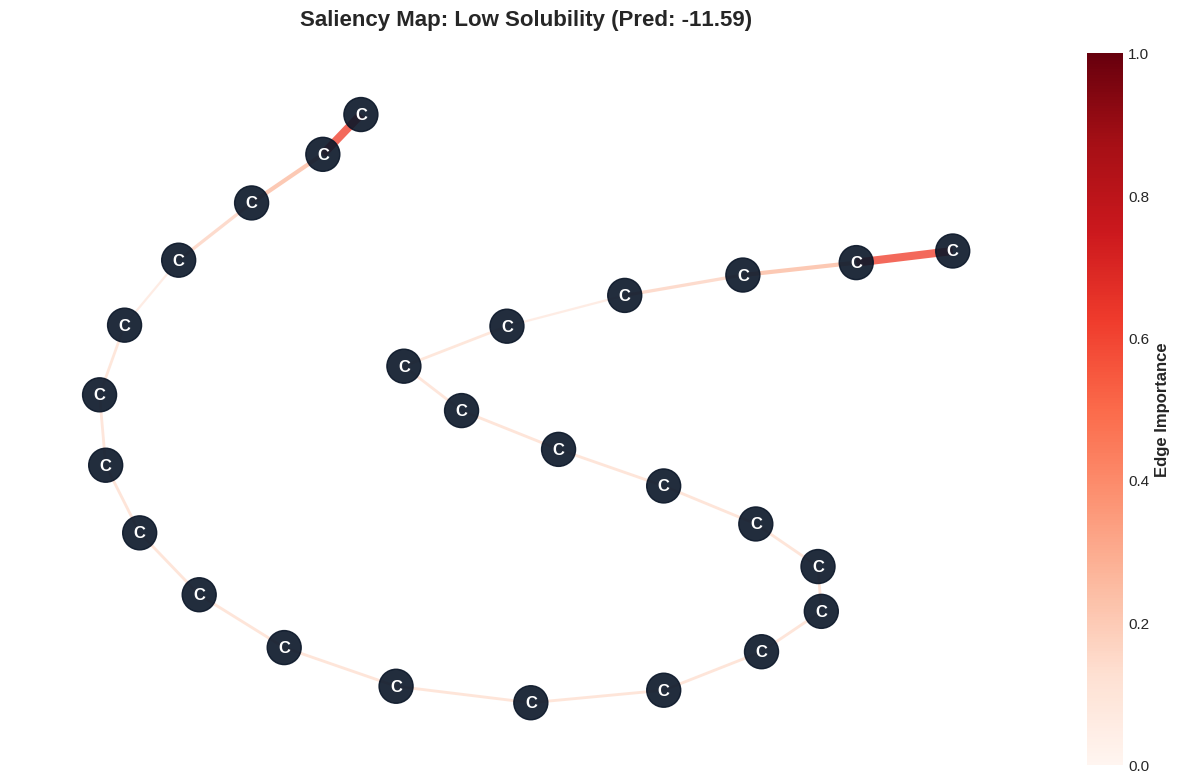


Example 2: Medium Solubility Molecule
Computing saliency attributions...

Top 5 most important bonds:
  1. Bond 3-4 (C-C): 0.5994
  2. Bond 0-1 (C-C): 0.4313
  3. Bond 5-6 (C-C): 0.4099
  4. Bond 2-3 (C-C): 0.2467
  5. Bond 1-2 (C-C): 0.1374


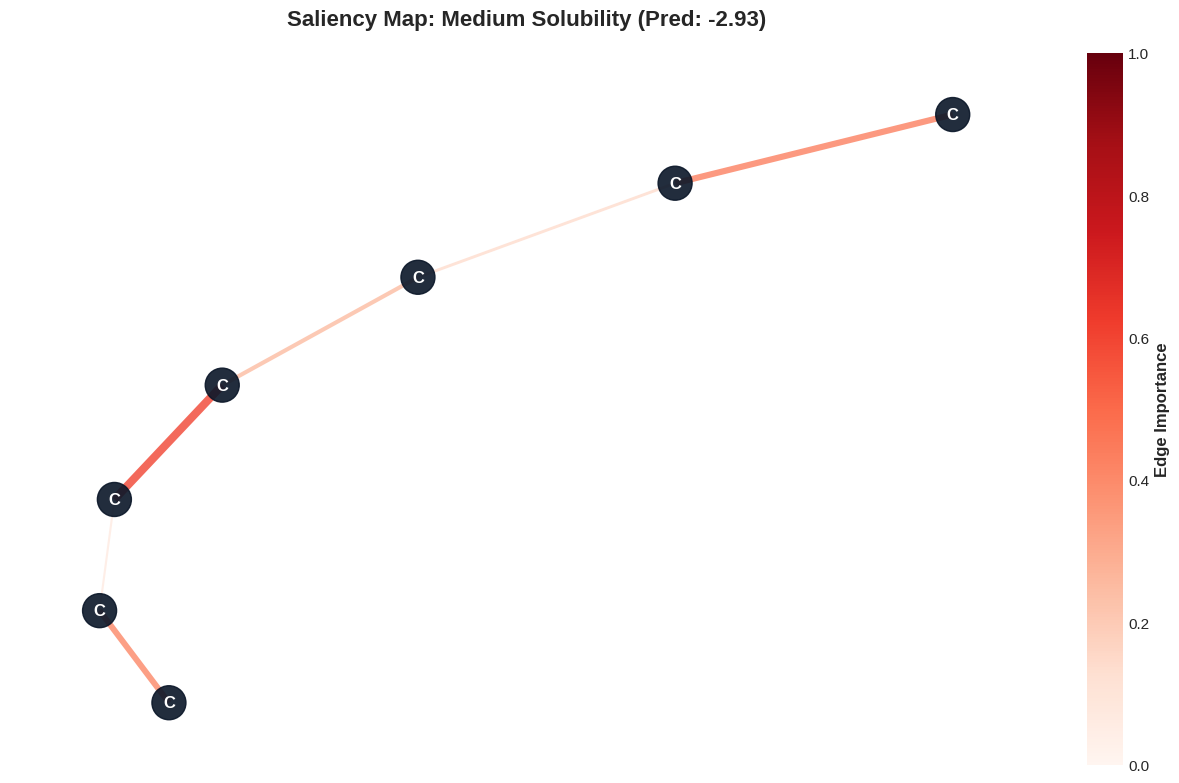


Example 3: High Solubility Molecule
Computing saliency attributions...

Top 5 most important bonds:
  1. Bond 1-2 (C-C): 0.6356
  2. Bond 4-6 (C-C): 0.6356
  3. Bond 0-1 (O-C): 0.6025
  4. Bond 6-7 (C-O): 0.6025
  5. Bond 2-3 (C-O): 0.3527


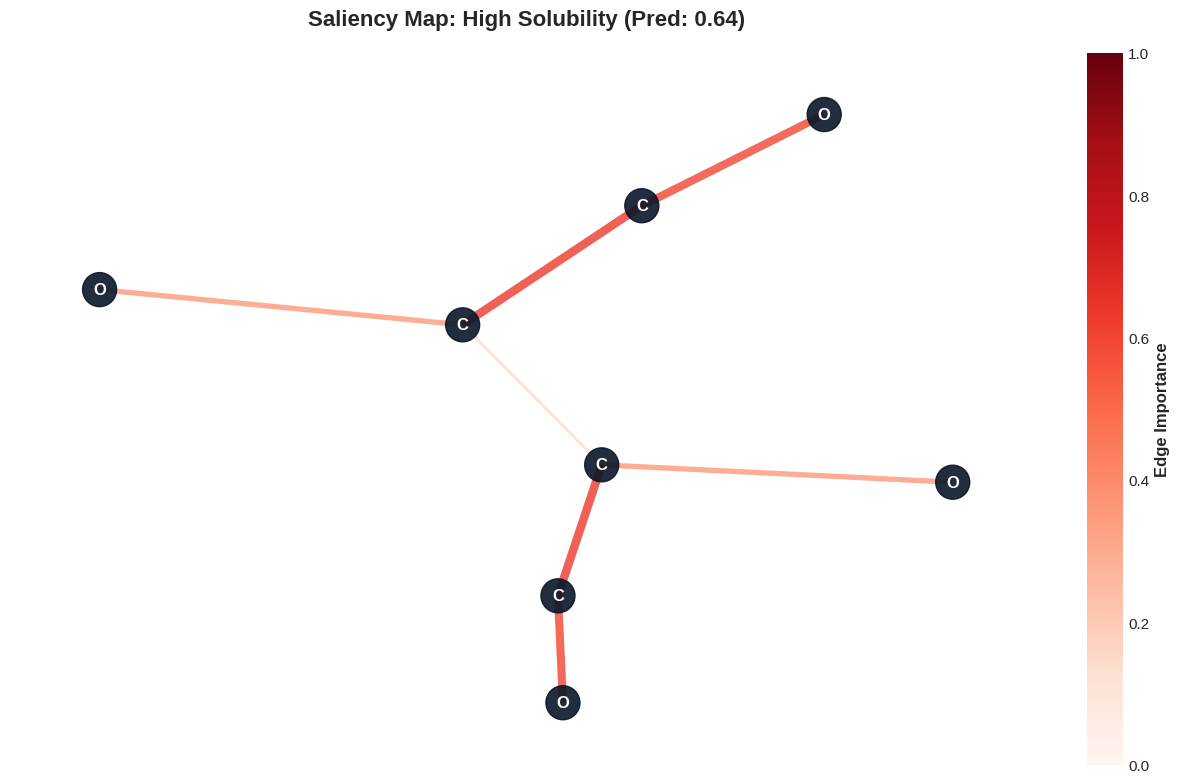


✓ Saliency analysis complete!

Interpretation Guide:
  - Darker red edges = More important for prediction
  - Thicker edges = Higher attribution score
  - Validate against chemical intuition (e.g., polar groups for solubility)


In [38]:
print_section_header("Method 1: Saliency-Based Explanations", "📊")

# Redefine helper function to fix Captum 0-dim tensor error
def model_forward_for_explainability(edge_mask, data, model, target_idx=0):
    """
    Forward pass through the model with edge masking for explainability.
    Fixed to return 1D tensor for Captum compatibility.
    """
    # Create batch tensor for single molecule
    batch = torch.zeros(data.x.shape[0], dtype=torch.long, device=data.x.device)

    # Create a modified data object with edge weights
    data_masked = data.clone()

    # Forward pass components
    x = model.atom_emb(data_masked.x)
    h = x.unsqueeze(0)
    edge_attr = model.bond_emb(data_masked.edge_attr)

    # Apply edge masking to edge features
    if hasattr(data_masked, 'edge_attr') and data_masked.edge_attr is not None:
        edge_attr = edge_attr * edge_mask.unsqueeze(1)

    # Message passing with masked edges
    for i in range(model.num_mp_steps):
        m = F.relu(model.conv(x, data_masked.edge_index, edge_attr))
        x, h = model.gru(m.unsqueeze(0), h)
        x = x.squeeze(0)

    # Readout
    x = global_add_pool(x, batch)
    out = model.mlp(x)

    # Fix: Return 1D tensor instead of scalar
    return out.view(-1)

# Redefine explain_molecule to fix cuDNN RNN backward error AND BatchNorm error
def explain_molecule(
    data,
    model,
    method='integrated_gradients',
    n_steps=50,
    device='cpu'
):
    """
    Explain a molecular graph prediction using Captum.
    Refactored to use model.train() to support cuDNN RNN gradients,
    while keeping BatchNorm in eval mode to handle batch_size=1.
    """
    # FIX 1: Switch to train mode to enable cuDNN RNN backward pass
    model.train()

    # FIX 2: Set BatchNorm layers to eval mode to avoid "Expected more than 1 value" error
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm1d):
            module.eval()

    data = data.to(device)

    # Create edge mask (all edges present initially)
    num_edges = data.edge_index.shape[1]
    edge_mask = torch.ones(num_edges, requires_grad=True, device=device)

    # Wrap model forward function
    def forward_func(edge_mask):
        return model_forward_for_explainability(edge_mask, data, model)

    # Compute attributions
    if method == 'saliency':
        explainer = Saliency(forward_func)
        attributions = explainer.attribute(edge_mask, abs=True)
    elif method == 'integrated_gradients':
        # Baseline: no edges (edge_mask = 0)
        baseline = torch.zeros_like(edge_mask)
        explainer = IntegratedGradients(forward_func)
        attributions = explainer.attribute(
            edge_mask,
            baselines=baseline,
            n_steps=n_steps
        )
    else:
        raise ValueError(f"Unknown method: {method}")

    # Convert to numpy and normalize
    attr = attributions.detach().cpu().numpy()
    attr = np.abs(attr)

    # Normalize to [0, 1]
    if attr.max() > 0:
        attr = attr / attr.max()

    return attr

print("Computing saliency maps for example molecules...\n")

for i, (idx, smiles, pred) in enumerate(examples_to_explain):
    print(f"\n{'='*70}")
    print(f"Example {i+1}: {'Low' if i==0 else 'Medium' if i==1 else 'High'} Solubility Molecule")
    print(f"{'='*70}")

    # Get graph data
    data = graph_list[idx].clone()

    # Compute saliency
    print("Computing saliency attributions...")
    attributions = explain_molecule(
        data=data,
        model=model,
        method='saliency',
        device=device
    )

    # Aggregate for undirected edges
    edge_attr_dict = aggregate_edge_directions(attributions, data)

    # Print top important bonds
    sorted_edges = sorted(edge_attr_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop 5 most important bonds:")
    mol = Chem.MolFromSmiles(smiles)
    for rank, ((u, v), score) in enumerate(sorted_edges[:5], 1):
        # Get atom symbols
        atom_u = mol.GetAtomWithIdx(u).GetSymbol()
        atom_v = mol.GetAtomWithIdx(v).GetSymbol()
        print(f"  {rank}. Bond {u}-{v} ({atom_u}-{atom_v}): {score:.4f}")

    # Visualize
    draw_molecule_with_attributions(
        smiles=smiles,
        edge_attributions_dict=edge_attr_dict,
        title=f"Saliency Map: {'Low' if i==0 else 'Medium' if i==1 else 'High'} Solubility (Pred: {pred:.2f})"
    )

print("\n✓ Saliency analysis complete!")
print("\nInterpretation Guide:")
print("  - Darker red edges = More important for prediction")
print("  - Thicker edges = Higher attribution score")
print("  - Validate against chemical intuition (e.g., polar groups for solubility)")


🎯  Method 2: Integrated Gradients Explanations

Computing Integrated Gradients for example molecules...
(This is more robust than Saliency but takes longer)


Example 1: Low Solubility Molecule
Computing Integrated Gradients (50 steps)...

Top 5 most important bonds:
  1. Bond 4-5 (C-C): 0.7297
  2. Bond 20-21 (C-C): 0.7297
  3. Bond 2-3 (C-C): 0.7213
  4. Bond 22-23 (C-C): 0.7213
  5. Bond 6-7 (C-C): 0.7122


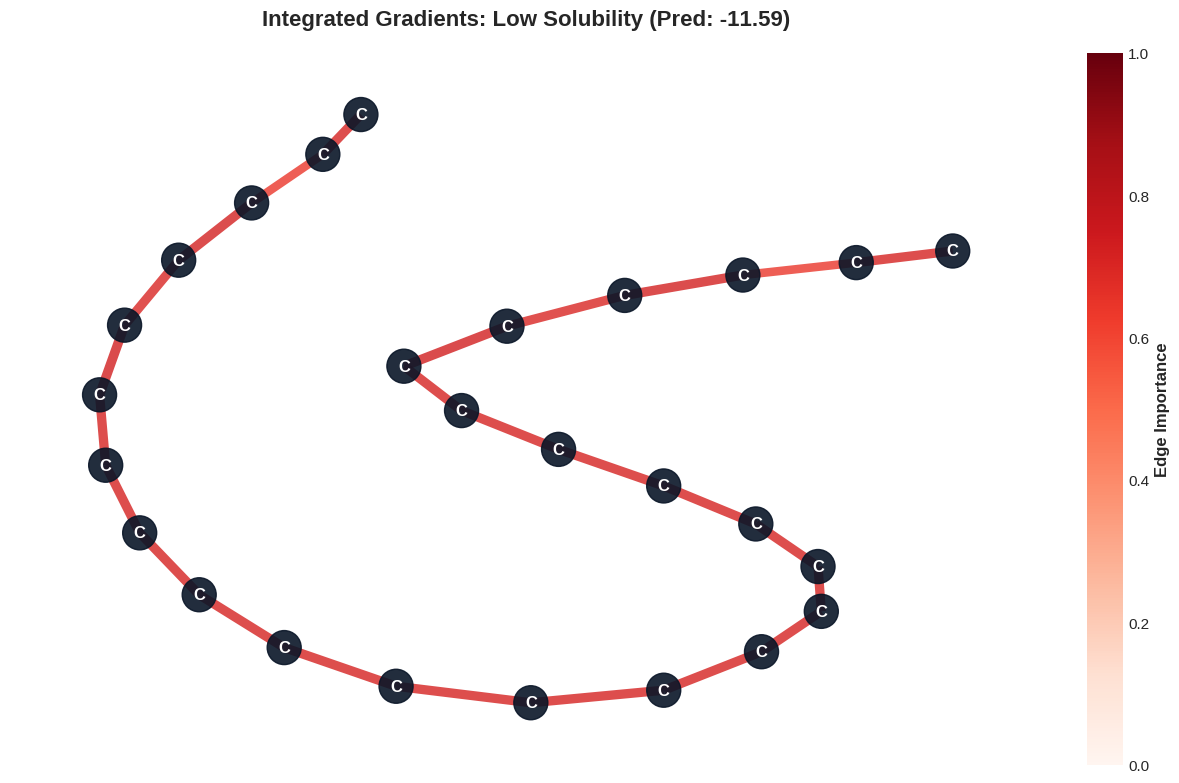


Example 2: Medium Solubility Molecule
Computing Integrated Gradients (50 steps)...

Top 5 most important bonds:
  1. Bond 0-1 (C-C): 0.7048
  2. Bond 1-2 (C-C): 0.5238
  3. Bond 2-3 (C-C): 0.5015
  4. Bond 5-6 (C-C): 0.4758
  5. Bond 3-4 (C-C): 0.1861


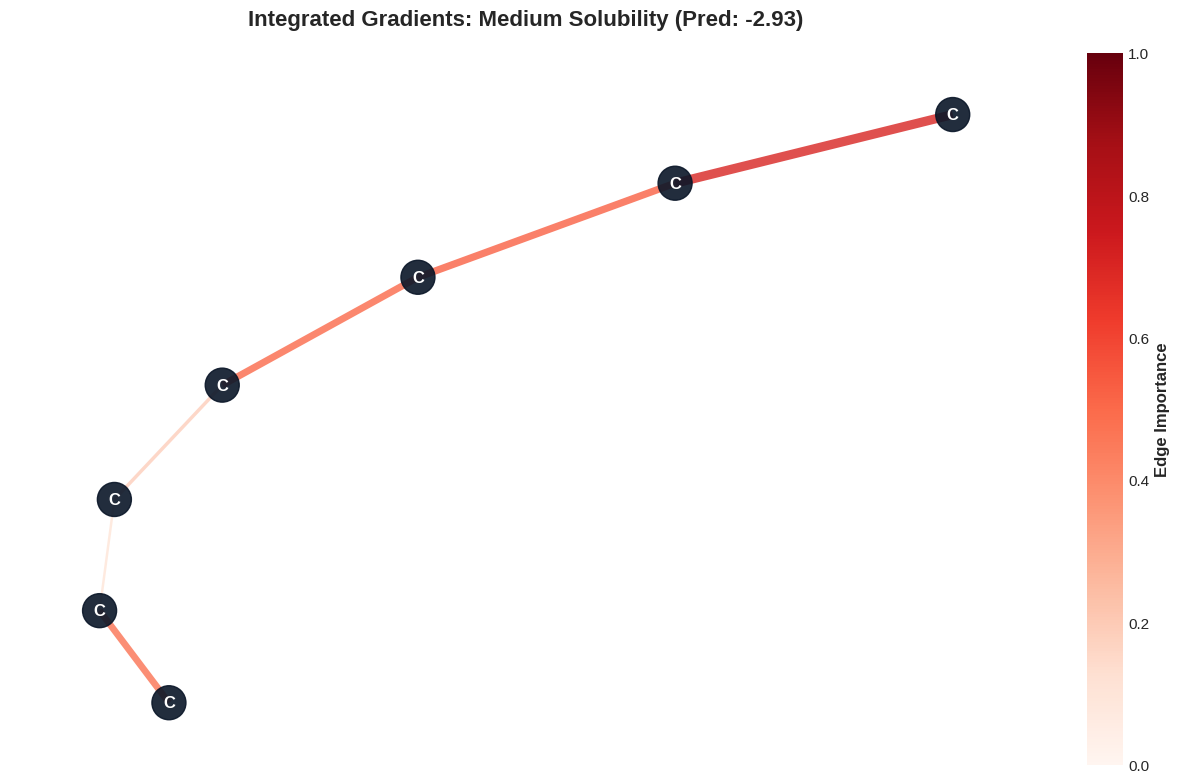


Example 3: High Solubility Molecule
Computing Integrated Gradients (50 steps)...

Top 5 most important bonds:
  1. Bond 0-1 (O-C): 0.9898
  2. Bond 6-7 (C-O): 0.9898
  3. Bond 4-6 (C-C): 0.2583
  4. Bond 1-2 (C-C): 0.2583
  5. Bond 2-3 (C-O): 0.1925


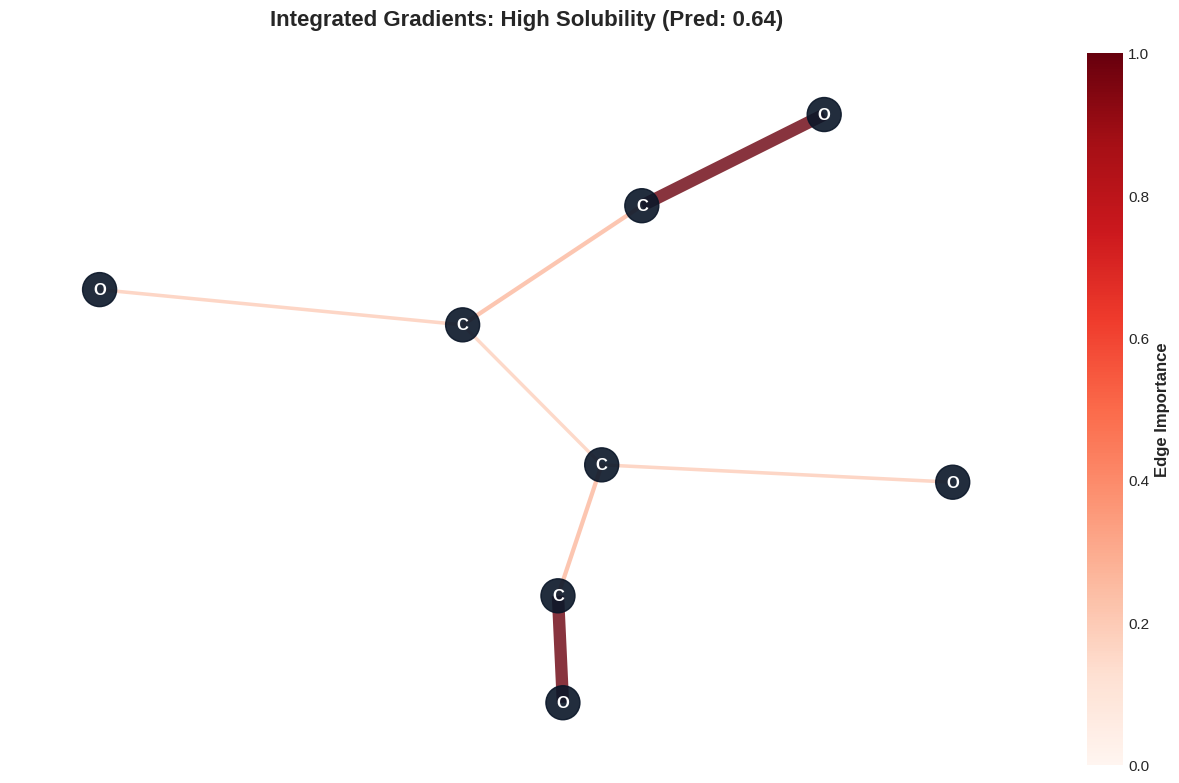


✓ Integrated Gradients analysis complete!

Key Differences from Saliency:
  - IG accumulates gradients along path from baseline (no edges) to actual graph
  - More stable and less affected by gradient saturation
  - Better theoretical guarantees (completeness + sensitivity axioms)
  - Generally produces cleaner, more interpretable attributions


In [42]:
print_section_header("Method 2: Integrated Gradients Explanations", "🎯")

# Redefine helper function to handle Batched Inputs (Required for Integrated Gradients)
def model_forward_for_explainability(edge_mask, data, model, target_idx=0):
    """
    Forward pass through the model with edge masking for explainability.
    Handles both single-instance (1D mask) and batched (2D/Flattened mask) inputs.
    """
    # Get number of edges in the single graph
    num_edges_graph = data.edge_index.shape[1]

    # Robust batch detection
    # Case 1: 2D tensor [batch_size, num_edges]
    if edge_mask.dim() > 1:
        batch_size = edge_mask.shape[0]
        batched = True
    # Case 2: 1D tensor but flattened batch [batch_size * num_edges]
    # IntegratedGradients sometimes passes flattened inputs
    elif edge_mask.shape[0] > num_edges_graph and edge_mask.shape[0] % num_edges_graph == 0:
        batch_size = edge_mask.shape[0] // num_edges_graph
        batched = True
    else:
        batch_size = 1
        batched = False

    # 1. Prepare Data
    if batched:
        # We need to replicate the graph batch_size times for parallel processing
        # Use x.shape[0] for safety instead of data.num_nodes
        num_nodes = data.x.shape[0]

        # Replicate node features: [batch_size * num_nodes, feature_dim]
        x = model.atom_emb(data.x)
        x_batch = x.repeat(batch_size, 1)

        # Replicate edge attributes: [batch_size * num_edges, feature_dim]
        edge_attr = model.bond_emb(data.edge_attr)
        edge_attr_batch = edge_attr.repeat(batch_size, 1)

        # Create batched edge index (disjoint union)
        # Shift indices for each graph copy
        edge_indices = []
        for i in range(batch_size):
            edge_indices.append(data.edge_index + i * num_nodes)
        edge_index_batch = torch.cat(edge_indices, dim=1)

        # Flatten the mask to match batched edges: [batch_size * num_edges, 1]
        # This works for both 2D and flattened 1D inputs
        mask_expanded = edge_mask.view(-1).unsqueeze(1)

        # Apply mask
        edge_attr_final = edge_attr_batch * mask_expanded

        # Batch vector for readout: [0,0..0, 1,1..1, ... N,N..N]
        batch_vec = torch.arange(batch_size, device=data.x.device).repeat_interleave(num_nodes)

        # Initial hidden state for GRU: [1, batch_size * num_nodes, hidden_dim]
        h = x_batch.unsqueeze(0)
        curr_x = x_batch
        curr_edge_index = edge_index_batch

    else:
        # Single instance case (Saliency)
        x = model.atom_emb(data.x)
        h = x.unsqueeze(0)
        edge_attr = model.bond_emb(data.edge_attr)

        # Apply mask: [num_edges, 1]
        mask_expanded = edge_mask.unsqueeze(1)
        edge_attr_final = edge_attr * mask_expanded

        curr_x = x
        curr_edge_index = data.edge_index
        batch_vec = torch.zeros(data.x.shape[0], dtype=torch.long, device=data.x.device)

    # 2. Message Passing
    for i in range(model.num_mp_steps):
        m = F.relu(model.conv(curr_x, curr_edge_index, edge_attr_final))
        curr_x, h = model.gru(m.unsqueeze(0), h)
        curr_x = curr_x.squeeze(0)

    # 3. Readout
    x_pool = global_add_pool(curr_x, batch_vec)
    out = model.mlp(x_pool)

    return out.view(-1)

print("Computing Integrated Gradients for example molecules...")
print("(This is more robust than Saliency but takes longer)\n")

for i, (idx, smiles, pred) in enumerate(examples_to_explain):
    print(f"\n{'='*70}")
    print(f"Example {i+1}: {'Low' if i==0 else 'Medium' if i==1 else 'High'} Solubility Molecule")
    print(f"{'='*70}")

    # Get graph data
    data = graph_list[idx].clone()

    # Compute Integrated Gradients
    print("Computing Integrated Gradients (50 steps)...")
    attributions = explain_molecule(
        data=data,
        model=model,
        method='integrated_gradients',
        n_steps=50,
        device=device
    )

    # Aggregate for undirected edges
    edge_attr_dict = aggregate_edge_directions(attributions, data)

    # Print top important bonds
    sorted_edges = sorted(edge_attr_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"\nTop 5 most important bonds:")
    mol = Chem.MolFromSmiles(smiles)
    for rank, ((u, v), score) in enumerate(sorted_edges[:5], 1):
        # Get atom symbols
        atom_u = mol.GetAtomWithIdx(u).GetSymbol()
        atom_v = mol.GetAtomWithIdx(v).GetSymbol()
        print(f"  {rank}. Bond {u}-{v} ({atom_u}-{atom_v}): {score:.4f}")

    # Visualize
    draw_molecule_with_attributions(
        smiles=smiles,
        edge_attributions_dict=edge_attr_dict,
        title=f"Integrated Gradients: {'Low' if i==0 else 'Medium' if i==1 else 'High'} Solubility (Pred: {pred:.2f})"
    )

print("\n✓ Integrated Gradients analysis complete!")
print("\nKey Differences from Saliency:")
print("  - IG accumulates gradients along path from baseline (no edges) to actual graph")
print("  - More stable and less affected by gradient saturation")
print("  - Better theoretical guarantees (completeness + sensitivity axioms)")
print("  - Generally produces cleaner, more interpretable attributions")

### Interpreting the Results

#### What to Look For:

1. **Polar Groups for High Solubility**
   - Hydroxyl groups (-OH)
   - Carboxylic acids (-COOH)
   - Amines (-NH2)
   - These should show high attribution scores for high-solubility molecules

2. **Hydrophobic Groups for Low Solubility**
   - Long alkyl chains
   - Large aromatic systems
   - These should be highlighted for low-solubility molecules

3. **Method Comparison**
   - **Saliency**: Faster, but can be noisy
   - **Integrated Gradients**: Slower, but more robust and interpretable
   - In practice, IG often identifies more chemically meaningful patterns

#### Validation Strategies:

1. **Chemical Intuition**: Do the highlighted substructures make sense?
2. **Literature**: Compare with known SAR (structure-activity relationships)
3. **Consistency**: Do similar molecules show similar attribution patterns?
4. **Ablation**: Remove highlighted substructures and check prediction change

#### Common Pitfalls:

- **Over-interpretation**: High attribution ≠ causal relationship
- **Context matters**: Same group can have different importance in different molecules
- **Model artifacts**: Sometimes highlights dataset biases rather than true chemistry
- **Multiple explanations**: Same prediction can have multiple valid explanations

### Best Practices for GNN Explainability

#### 1. Use Multiple Attribution Methods

No single method is perfect. Compare results across:
- Saliency (fast screening)
- Integrated Gradients (robust baseline)
- GNNExplainer (graph-specific, available in PyG)
- Attention weights (for GAT models)

#### 2. Aggregate Across Multiple Examples

```python
# Find common important substructures across a class
high_solubility_mols = [...] # Filter by property
common_attributions = []

for mol in high_solubility_mols:
    attr = explain_molecule(mol, model, 'integrated_gradients')
    common_attributions.append(attr)

# Average attributions to find consensus patterns
consensus = np.mean(common_attributions, axis=0)
```

#### 3. Use Explainability During Training

- **Model selection**: Choose models with interpretable explanations
- **Debugging**: Identify when model learns spurious correlations
- **Regularization**: Add losses that encourage sparse, interpretable explanations

#### 4. Combine with Domain Knowledge

- Consult medicinal chemists about highlighted substructures
- Compare with known pharmacophores
- Use as hypothesis generation, not truth

#### 5. Quantitative Evaluation

Where possible, validate explanations quantitatively:

```python
# Remove attributed substructure and measure prediction change
def evaluate_attribution(mol, important_bonds):
    original_pred = model(mol)
    
    # Create variant without important bonds
    mol_modified = remove_bonds(mol, important_bonds)
    modified_pred = model(mol_modified)
    
    # Large change = good attribution
    return abs(original_pred - modified_pred)
```

### Further Resources

**Documentation:**
- [Captum Documentation](https://captum.ai/)
- [PyG Explainability Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html)

**Recent Papers (2024-2025):**
- [Drug discovery and mechanism prediction with explainable GNNs](https://www.nature.com/articles/s41598-024-83090-3) - Scientific Reports, 2024
- [Explainable AI in Drug Discovery](https://wires.onlinelibrary.wiley.com/doi/10.1002/wcms.70049) - WIREs Computational Molecular Science, 2025

**Alternative Approaches:**
- **GNNExplainer**: Native PyG implementation optimized for graphs
- **PGExplainer**: Learns parameterized explainer model
- **SubgraphX**: Monte Carlo Tree Search for subgraph explanations

---

**You've now learned how to:**
- ✓ Install and configure Captum for GNN explainability
- ✓ Compute Saliency and Integrated Gradients attributions
- ✓ Visualize attributions on molecular structures
- ✓ Interpret results in chemical context
- ✓ Apply best practices for trustworthy explanations

**Next steps:** Try explaining your own molecular datasets and validate findings with domain experts!

## Further Reading

### Papers
1. **Gilmer et al. (2017)**: Neural Message Passing for Quantum Chemistry
2. **Yang et al. (2019)**: Analyzing Learned Molecular Representations (Chemprop)
3. **Xu et al. (2019)**: How Powerful are Graph Neural Networks? (GIN)
4. **Veličković et al. (2018)**: Graph Attention Networks (GAT)
5. **Schütt et al. (2017)**: SchNet - 3D molecular modeling

### Courses and Tutorials
- **Stanford CS224W**: Machine Learning with Graphs
- **PyG Tutorials**: https://pytorch-geometric.readthedocs.io/
- **DeepChem**: https://deepchem.io/
- **AI4Chem Course**: https://github.com/schwallergroup/ai4chem_course

### Software Libraries
- **PyTorch Geometric**: https://pytorch-geometric.readthedocs.io/
- **Chemprop**: https://github.com/chemprop/chemprop
- **DeepChem**: https://deepchem.io/
- **RDKit**: https://www.rdkit.org/
- **OGB**: https://ogb.stanford.edu/

### Research Groups
- **Gomes Group (CMU)**: Molecular machine learning and retrosynthesis
- **Coley Group (MIT)**: Chemprop, reaction prediction
- **Schwaller Group (EPFL)**: Transformer models for chemistry
- **Isayev Group (CMU)**: ANI neural network potentials

---

## Congratulations!

You've completed the GNN Molecular Property Prediction tutorial!

### What You've Learned:
✓ Why graphs are natural for molecules
✓ How to convert SMILES to graph representations
✓ Message-passing neural network theory
✓ Implementing MPNNs with PyTorch Geometric
✓ Training and evaluating GNN models
✓ Visualizing learned representations
✓ Using production tools like Chemprop
✓ Debugging common issues
✓ Paths for further exploration

### Next Steps:
1. Try different molecular properties (QM9, MoleculeNet)
2. Experiment with different GNN architectures
3. Apply to your own molecular datasets
4. Explore 3D equivariant models
5. Implement uncertainty quantification
6. Deploy models in production

**Happy molecule learning!**

---

*Tutorial developed by the Gomes Research Group at CMU*  
*Questions? Open an issue on GitHub or contact the course staff*